# ENSEMBLE METHODS

Notebook Compliled by:
1. Norman Mwapea
2. Kiprono Langat
3. Pauline Kariuki
4. Judith
5. Alvin
6. Wesley

Ensemble learning sits at the heart of modern machine learning. Sometimes one model just isn’t enough, is it?.

Instead of betting everything on a single learner, ensembles pull together the strengths of many, smoothing out weaknesses and often delivering stronger, more reliable predictions.

In this notebook, we’ll walk through three ensemble techniques that have become staples in the field:
- Decision Trees
- Random Forests
- XGBoost

Each brings something different; Decision Trees are simple and easy to interpret, Random Forests add stability by averaging across many trees, and XGBoost pushes performance to the next level with gradient boosting.

We’ll be applying all three models to **scikit-learn’s Breast Cancer dataset.**  We will train them, compare them, and see which one truly shines in this setting. Along the way, we’ll get a sense of not just which model performs best, but *why* it does.

First we import all necessary libraries.

In [1]:
# Utilities
import warnings
warnings.filterwarnings('ignore')

# Mathematical Operations
import numpy as np

# Data Manipulation
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')
import seaborn as sns

# Machine Learning - Preprocessing
from sklearn.preprocessing import (
    LabelEncoder,
    StandardScaler
)

# Machine Learning - Model Selection & Evaluation
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
)
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    roc_auc_score,
    f1_score
)

# Machine Learning Models
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

# Advanced Models
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.utils.class_weight import compute_class_weight

# Handling Class Imbalance
from imblearn.over_sampling import SMOTE

Load the data

In [2]:
from sklearn.datasets import load_breast_cancer

# Load dataset
data = load_breast_cancer()

# Convert to DataFrame
df = pd.DataFrame(data.data, columns=data.feature_names)

# Add target column
df["target"] = data.target

# Print dataset
df

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0


## DATA UNDERSTANDING

Before diving into modeling, it’s only fair to get acquainted with the data; we need to know exactly what we’re dealing with. In this stage, we’ll explore:

1. Shape – how many rows and columns we have.
2. Column names – checking if they’re consistent or need cleaning for readability.
3. Metadata – understanding feature types and target distribution.
4. Descriptive statistics – a quick numerical summary to spot trends and anomalies.
5. Data quality checks – scanning for duplicates and missing values (because no one likes hidden surprises).

Once that’s clear, we’ll move on to examining outliers, i.e; identifying them, and if necessary, figuring out the best way to handle them.

In [3]:
# Check dataset shape
print(f"The dataset has {df.shape[0]} records and {df.shape[1]} columns.")

The dataset has 569 records and 31 columns.


Check columns.

In [4]:
# Check column names
df.columns

Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension',
       'target'],
      dtype='object')

Replace whitespace in column names with underscore ('_').

In [5]:
# Standardise column names
df.columns = df.columns.str.replace(' ', '_')

# Sanity check
df.columns

Index(['mean_radius', 'mean_texture', 'mean_perimeter', 'mean_area',
       'mean_smoothness', 'mean_compactness', 'mean_concavity',
       'mean_concave_points', 'mean_symmetry', 'mean_fractal_dimension',
       'radius_error', 'texture_error', 'perimeter_error', 'area_error',
       'smoothness_error', 'compactness_error', 'concavity_error',
       'concave_points_error', 'symmetry_error', 'fractal_dimension_error',
       'worst_radius', 'worst_texture', 'worst_perimeter', 'worst_area',
       'worst_smoothness', 'worst_compactness', 'worst_concavity',
       'worst_concave_points', 'worst_symmetry', 'worst_fractal_dimension',
       'target'],
      dtype='object')

Get metadata.

In [6]:
# Metadata
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean_radius              569 non-null    float64
 1   mean_texture             569 non-null    float64
 2   mean_perimeter           569 non-null    float64
 3   mean_area                569 non-null    float64
 4   mean_smoothness          569 non-null    float64
 5   mean_compactness         569 non-null    float64
 6   mean_concavity           569 non-null    float64
 7   mean_concave_points      569 non-null    float64
 8   mean_symmetry            569 non-null    float64
 9   mean_fractal_dimension   569 non-null    float64
 10  radius_error             569 non-null    float64
 11  texture_error            569 non-null    float64
 12  perimeter_error          569 non-null    float64
 13  area_error               569 non-null    float64
 14  smoothness_error         5

*Observation:*

The dataset is largely numeric. Meaning no encoding necessary but scaling and log transformation will definitely be necessary.

Get basic descriptive statistics.

In [7]:
# Get statistical summary
df.describe()

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,mean_symmetry,mean_fractal_dimension,...,worst_texture,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension,target
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,0.627417
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,0.483918
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,0.000000
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,0.000000
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,1.000000
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,1.000000
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,1.000000


Plot this for easier reading.

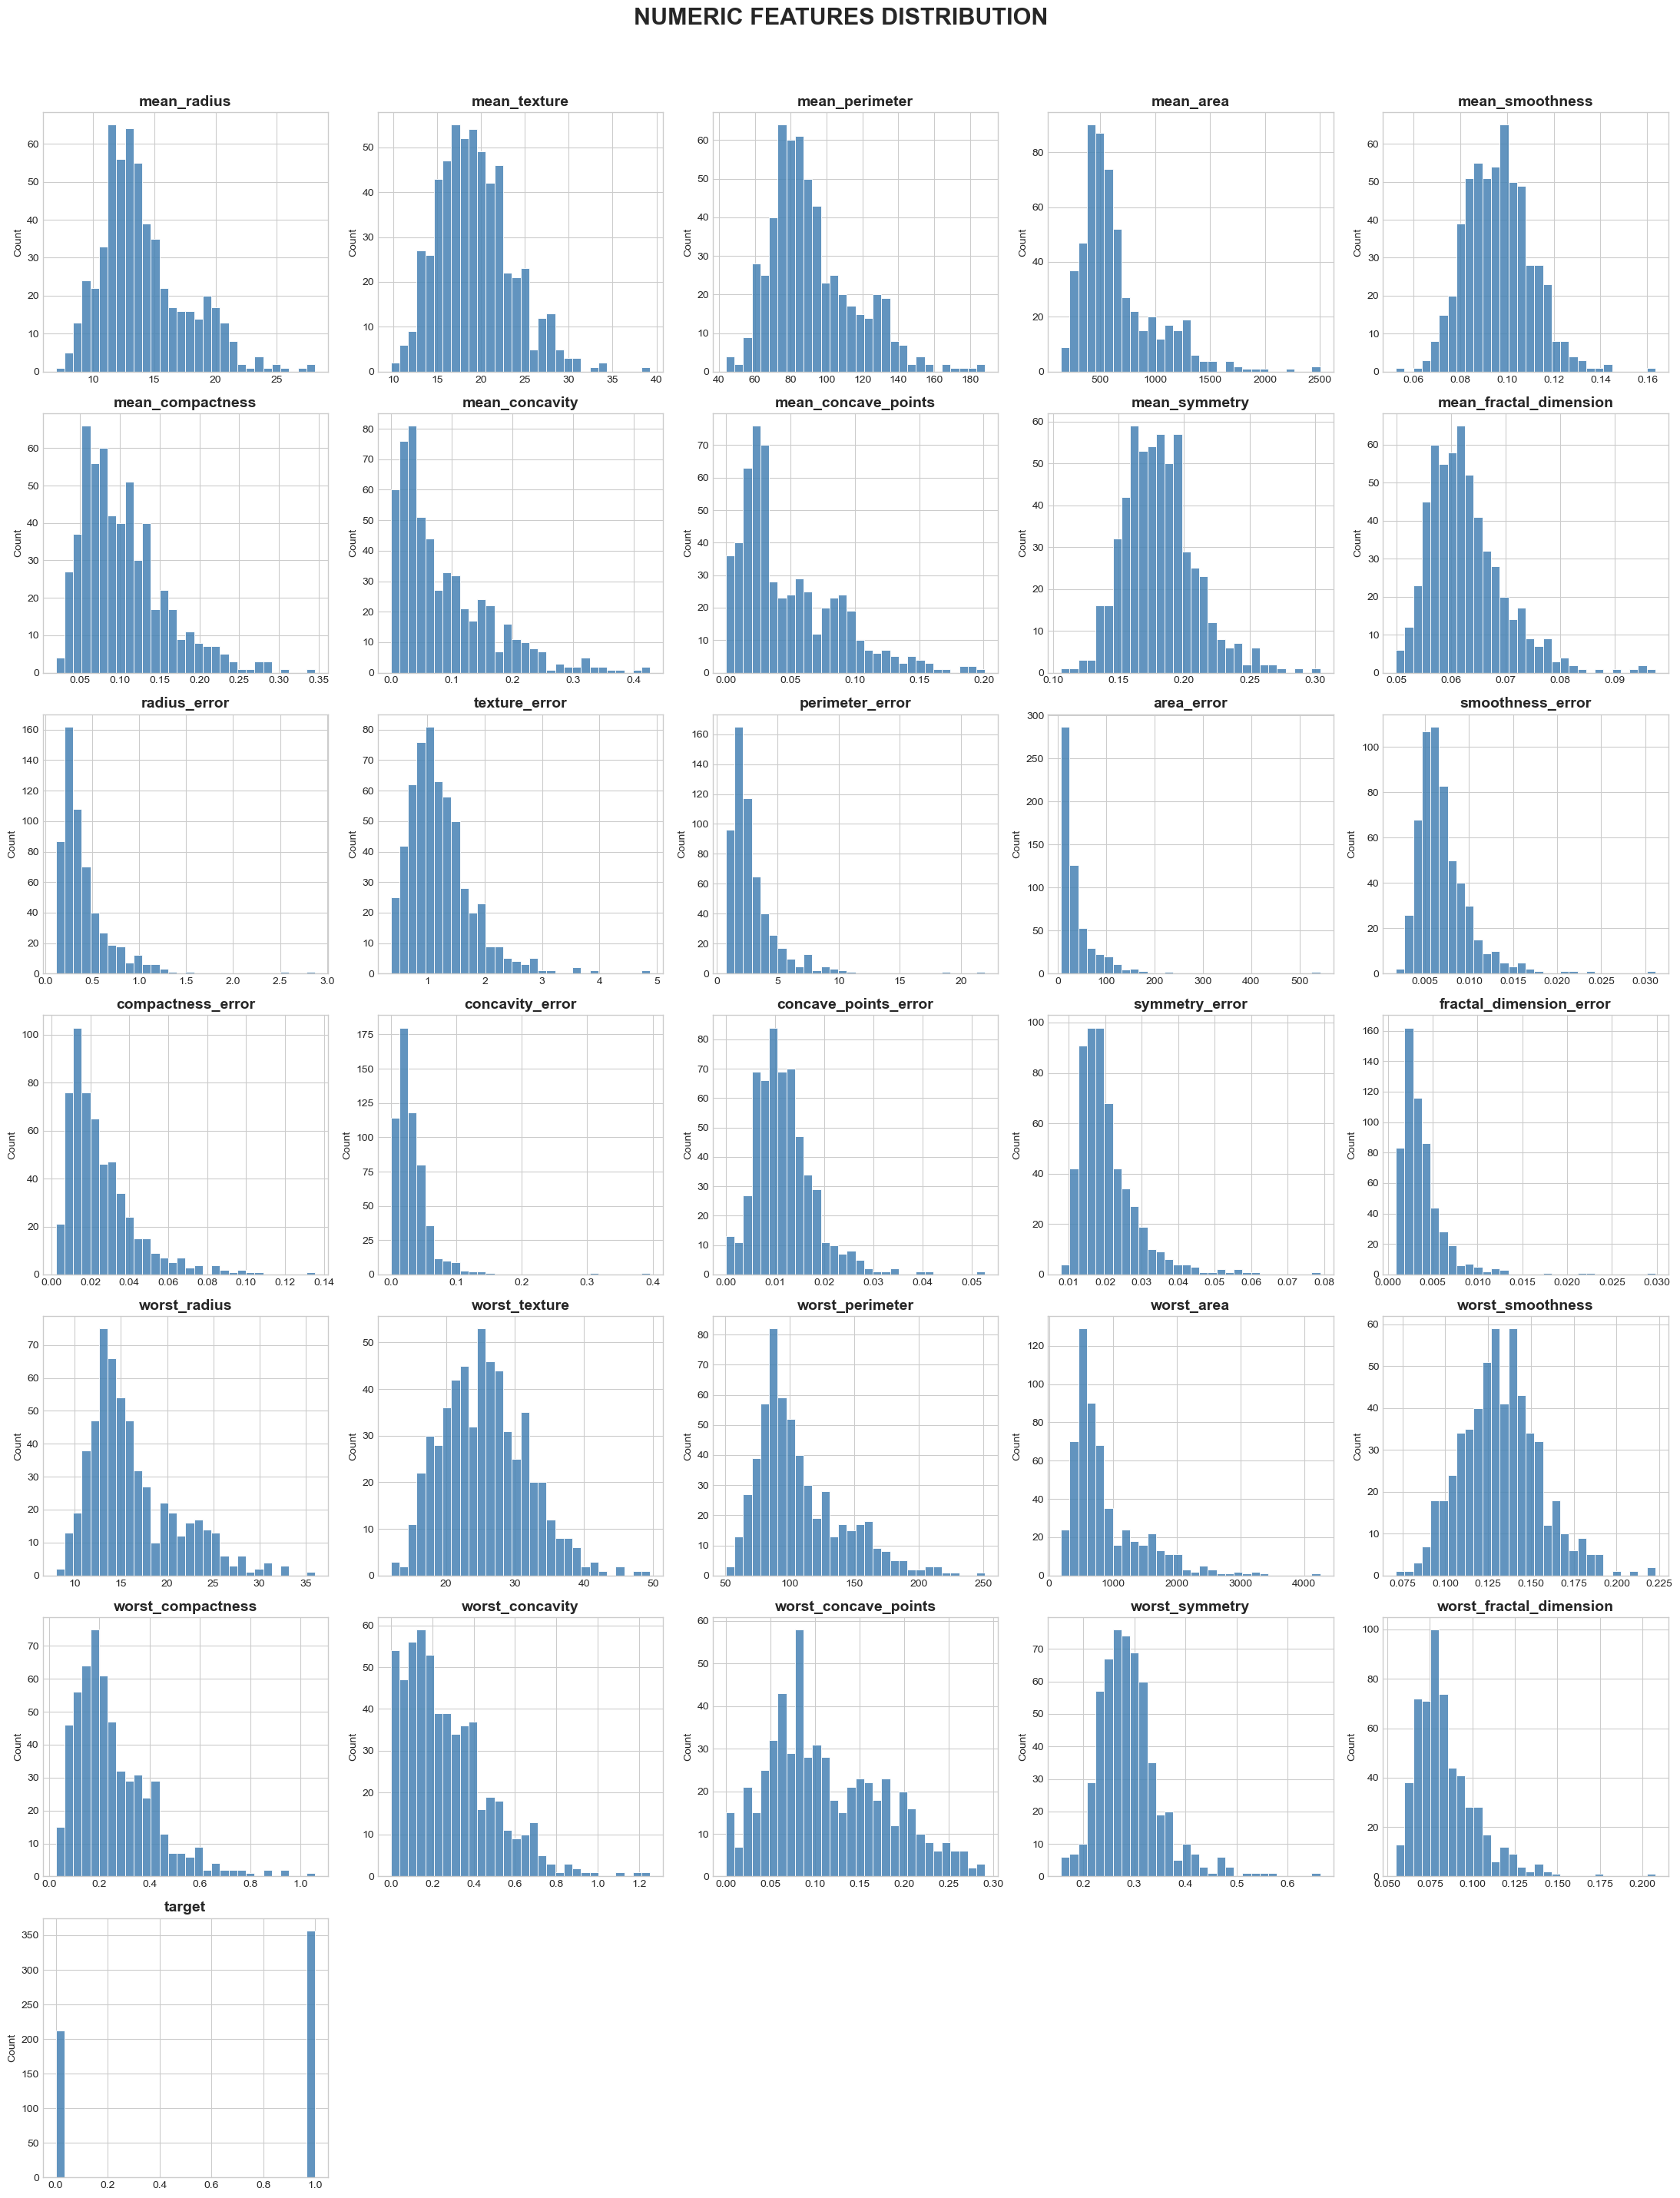

In [8]:
# Save columns in variable
cols = df.columns

# Set the plot grid
n_cols = 5
n_rows = int(len(cols) / n_cols) + 1

plt.figure(figsize=(22, 4*n_rows))
plt.suptitle("NUMERIC FEATURES DISTRIBUTION", fontsize=22, fontweight='semibold', y=1.02)

for i, col in enumerate(cols, 1):
    plt.subplot(n_rows, n_cols, i)

    sns.histplot(
        data=df,
        x=col,
        bins=30,
        color='steelblue',
        edgecolor='white',
        alpha=0.85
    )

    plt.title(col, fontsize=14, weight='semibold')
    plt.xlabel("")
    plt.ylabel("Count")

plt.tight_layout()
plt.show()

*Observation:*

- The features show a wide range of scales: some are tightly clustered (like smoothness around 0.1), while others stretch massively (like area and perimeter).
- Several variables are heavily skewed, with maximum values far above the 75th percentile; sure fire sign of outliers.
- The median of the target is 1.0, hinting at more malignant cases in the sample.

Data Quality Check.

In [9]:
# Check for duplicates and missingness
print("Duplicates:", df.duplicated().sum())
print("Missing Values:", df.isna().sum().sum())

Duplicates: 0
Missing Values: 0


Check outlier distribution.

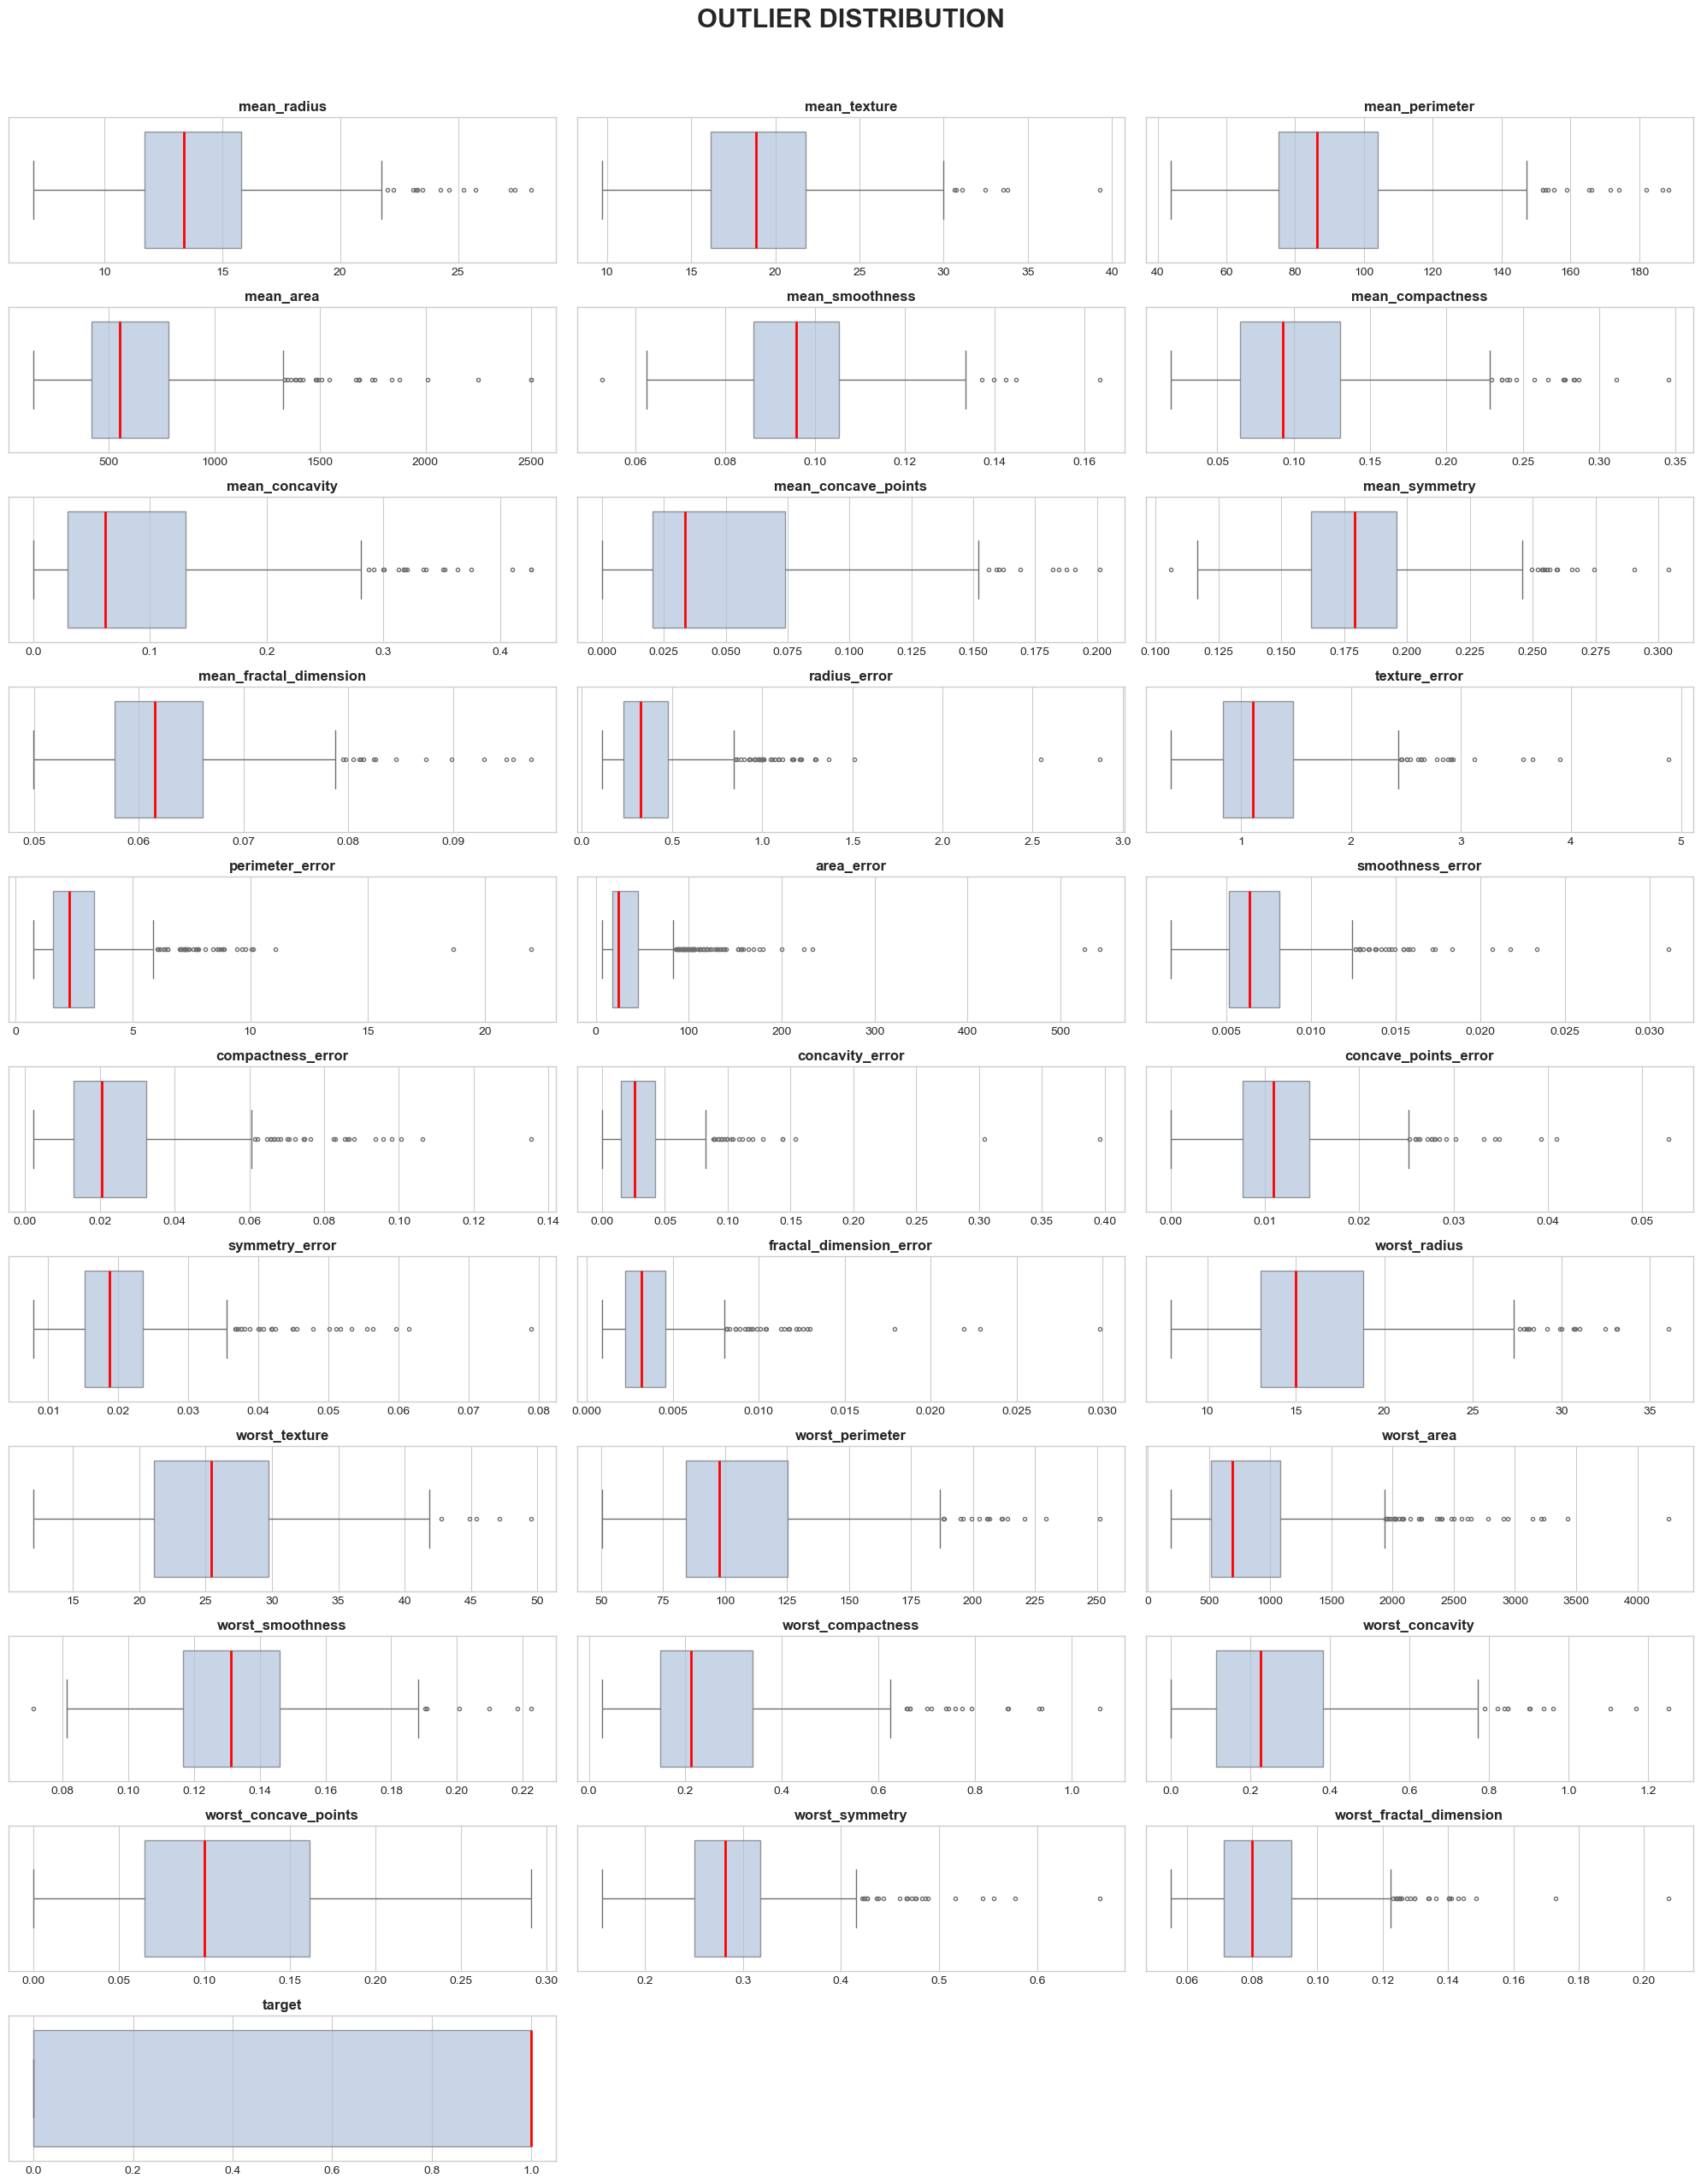

In [10]:
# Save columns in variable
cols = df.columns

plt.figure(figsize=(20, 25))
plt.suptitle("OUTLIER DISTRIBUTION", fontsize=22, fontweight='semibold', y=1.02)

for i, col in enumerate(cols, 1):
    plt.subplot(len(cols) // 3 + 1, 3, i)
    sns.boxplot(
        x=df[col],
        color="skyblue",
        fliersize=3,
        linewidth=1,
        boxprops=dict(alpha=0.7, facecolor="lightsteelblue"),
        medianprops=dict(color="red", linewidth=2)
    )
    plt.title(col, fontsize=12, fontweight="bold")
    plt.xlabel("")

plt.tight_layout()
plt.show()

*Comment on Outliers:*

These are genuine outliers so we will leave them as is.

# MODELING

The dataset turned out to be much cleaner than expected—no hidden mess to slow us down. With a solid grasp of the features and their distributions, it’s time to shift gears into modeling.

Our workflow will unfold in three phases:

- **Baseline modeling** – Train each model with default parameters to set a performance benchmark.
- **Imbalance handling** – Address class distribution to ensure fairer learning and evaluation.
- **Tuned modeling** – Apply hyperparameter tuning with GridSearchCV to squeeze out maximum performance.

## DATA PREPROCESSING

Check target distribution to assess if it is imbalanced.

        Count  Percentage
target                   
1         357       62.74
0         212       37.26 



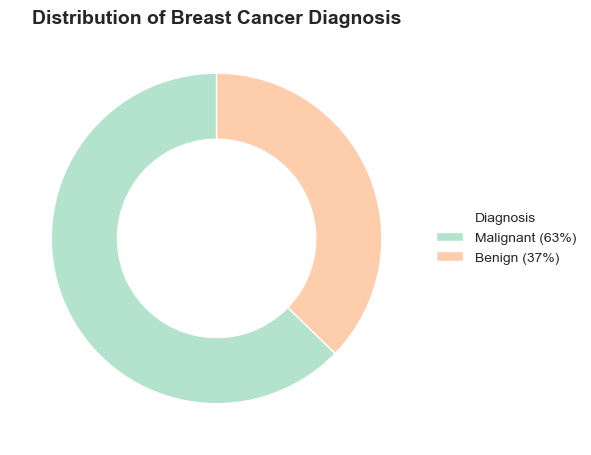

In [11]:
# Work on a copy
model_df = df.copy(deep=True)

# Get counts and percentages of target variable
target_counts = model_df['target'].value_counts()
target_percent = model_df['target'].value_counts(normalize=True) * 100

# Combine into a single DataFrame
target_summary = pd.DataFrame({
    'Count': target_counts,
    'Percentage': target_percent.round(2)
})

print(target_summary, "\n")

# Visualise
plt.figure(figsize=(6, 6))
colors = plt.cm.Pastel2.colors

# Total for percentages
total = target_counts.sum()

# Create donut chart
wedges, texts = plt.pie(
    target_counts,
    labels=None,
    startangle=90,
    colors=colors,
    wedgeprops={'width': 0.4, 'edgecolor': 'white'}
)

# Build labels
legend_labels = [
    f"{'Malignant' if label == 1 else 'Benign'} ({count/total:.0%})"
    for label, count in zip(target_counts.index, target_counts)
]

# Add legend
plt.legend(
    wedges,
    legend_labels,
    title="Diagnosis",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1),
    fontsize=10
)

# Title
plt.title("Distribution of Breast Cancer Diagnosis", fontsize=14,
          fontweight='semibold', ha='center')

plt.tight_layout()
plt.show()

*Observation:*
- Target is clearly imbalanced. We will deal with that later on.

For now, we separate the target from the features.

In [12]:
# Separate target from features
X = model_df.drop('target', axis=1)
y = model_df['target']

Next, we split the data into training set and testing set.

In [13]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Check shape
X_train.shape, y_train.shape, y_test.shape, y_test.shape

((455, 30), (455,), (114,), (114,))

To identify which variables may benefit from a log transformation, we can calculate skewness for all numeric features and flag those that are heavily skewed. A common rule of thumb is to consider variables with absolute skewness greater than 1 as “highly skewed.”

In [14]:
# Calculate skewness for all numeric features
skewness = model_df.skew().sort_values(ascending=False)

# Threshold for skewness
threshold = 1

# Filter features with high skewness
skewed_vars = skewness[abs(skewness) > threshold]

print("Highly skewed variables:"+"\n")
#print()
print(skewed_vars)

Highly skewed variables:

area_error                 5.447186
concavity_error            5.110463
fractal_dimension_error    3.923969
perimeter_error            3.443615
radius_error               3.088612
smoothness_error           2.314450
symmetry_error             2.195133
compactness_error          1.902221
worst_area                 1.859373
worst_fractal_dimension    1.662579
texture_error              1.646444
mean_area                  1.645732
worst_compactness          1.473555
concave_points_error       1.444678
worst_symmetry             1.433928
mean_concavity             1.401180
mean_fractal_dimension     1.304489
mean_compactness           1.190123
mean_concave_points        1.171180
worst_concavity            1.150237
worst_perimeter            1.128164
worst_radius               1.103115
dtype: float64


Apply a log transformation to normalize their distributions. New log-transformed columns are created for skewed variables, after which the original skewed columns are dropped, as they are no longer required.

In [15]:
# Skewed variables
skewed_vars = [
    "area_error", "concavity_error", "fractal_dimension_error", "perimeter_error",
    "radius_error", "smoothness_error", "symmetry_error", "compactness_error",
    "worst_area", "worst_fractal_dimension", "texture_error", "mean_area",
    "worst_compactness", "concave_points_error", "worst_symmetry",
    "mean_concavity", "mean_fractal_dimension", "mean_compactness",
    "mean_concave_points", "worst_concavity", "worst_perimeter", "worst_radius"
]

# Apply log transform on skewed columns
for var in skewed_vars:
    # Create transformed versions
    X_train[var + "_log"] = np.log1p(X_train[var])
    X_test[var + "_log"] = np.log1p(X_test[var])

# Drop the original skewed columns
X_train = X_train.drop(skewed_vars, axis=1)
X_test = X_test.drop(skewed_vars, axis=1)

Since the numerical features in our dataset live on different scales, we’ll bring them onto a level playing field through standardization. This ensures that no single feature dominates simply because of its magnitude.

We’ll use StandardScaler, which rescales each feature to have a mean of 0 and a standard deviation of 1, giving all variables an equal chance to contribute fairly during modeling.

In [16]:
# Feature Scaling
cols = X_train.columns

scaler = StandardScaler()
X_train[cols] = scaler.fit_transform(X_train[cols])
X_test[cols] = scaler.transform(X_test[cols])

Now we model!!

### 1. VANILLA MODELING

#### VANILLA DECISION TREES

In [17]:
# Initialize Vanilla Decision Tree
vanilla_dt = DecisionTreeClassifier()

# Fit model
vanilla_dt.fit(X_train, y_train)

DecisionTreeClassifier()

Check accuracy on training and testing data.

In [18]:
# Predict
y_pred = vanilla_dt.predict(X_test)

# Training accuracy
train_accuracy = vanilla_dt.score(X_train, y_train) * 100

# Test accuracy
test_accuracy = accuracy_score(y_test, y_pred) * 100

# Display
print(f"Training Accuracy: {train_accuracy:.2f}%")
print(f"Test Accuracy:     {test_accuracy:.2f}%")

Training Accuracy: 100.00%
Test Accuracy:     90.35%


The model is clearly overfit. Let's look at the confusion matrix;

Confusion Matrix:
 [[38  4]
 [ 7 65]] 



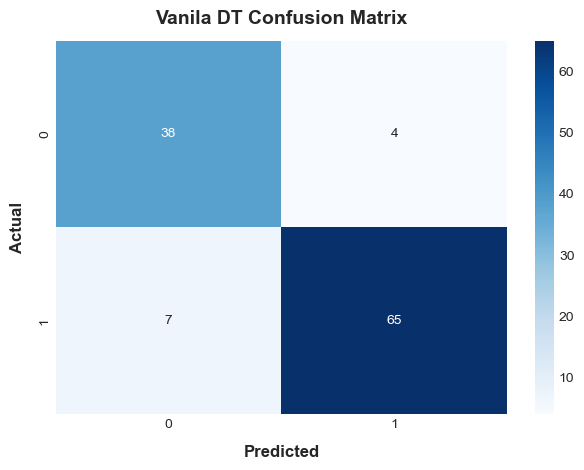

In [19]:
# Check Confusion Matrix
vanilla_matrix1 = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred), "\n")

# Visualise the confusion matrix
sns.heatmap(vanilla_matrix1, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted', fontsize=12, fontweight='semibold', labelpad=10)
plt.ylabel('Actual', fontsize=12, fontweight='semibold', labelpad=10)
plt.title('Vanila DT Confusion Matrix', fontsize=14, fontweight='semibold', pad=12)

plt.tight_layout()
plt.show()

*Interpretation:*

- Out of 42 benign cases, the model caught 39 correctly and raised 3 false alarms.
- Out of 72 malignant cases, it successfully detected 65, but missed 7, labeling them as benign.

ROC-AUC CURVE ANALYSIS

AUC: 0.904



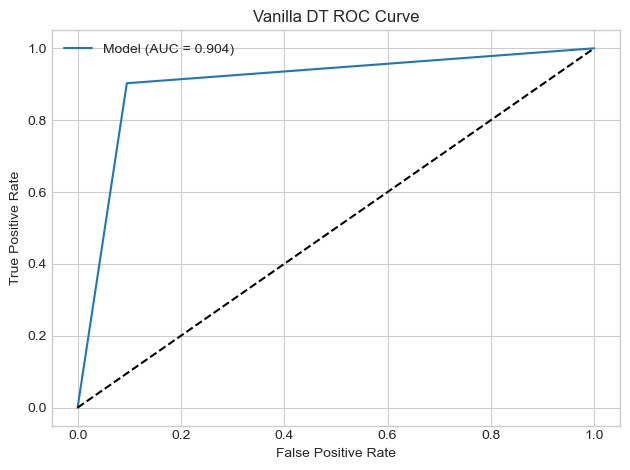

In [20]:
# Predict probabilities for the positive class
y_pred_proba = vanilla_dt.predict_proba(X_test)[:, 1]

# Compute AUC
auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC: {auc:.3f}")
print()

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f"Model (AUC = {auc:.3f})")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Vanilla DT ROC Curve")
plt.legend()
plt.tight_layout()
plt.show()

Check Classification Report.

In [21]:
# Classification report
print("Vanilla Decision Tree Classification Report:\n", classification_report(y_test, y_pred))

Vanilla Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.90      0.87        42
           1       0.94      0.90      0.92        72

    accuracy                           0.90       114
   macro avg       0.89      0.90      0.90       114
weighted avg       0.91      0.90      0.90       114



*Interpretation:*

For benign tumors (Class 0):
- The model correctly identifies about 9 out of 10 benign cases.
- However, in a small number of situations, it mistakenly labels a malignant tumor as benign. This is reflected in the precision of 81%; meaning that when the model predicts “benign,” it’s right most of the time but not always.

For malignant tumors (Class 1):
- The model is highly reliable when it flags malignancy.
- With a precision of 94%, nearly all of its “malignant” predictions are correct.
- It also manages to catch about 88% of all malignant cases. Still, that means a few malignant tumors are being missed.

Overall:
- The model achieves 89% accuracy. It leans slightly toward catching malignant cases correctly, but its weaker spot is occasionally downplaying a malignant case as benign.

#### VANILLA RANDOM FORESTS

In [22]:
# Instantiate model
vanilla_rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Train the model
vanilla_rf.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [23]:
# Predict
y_pred = vanilla_rf.predict(X_test)

# Training accuracy
train_accuracy = vanilla_rf.score(X_train, y_train) * 100

# Test accuracy
test_accuracy = accuracy_score(y_test, y_pred) * 100

# Display
print(f"Training Accuracy: {train_accuracy:.2f}%")
print(f"Test Accuracy:     {test_accuracy:.2f}%")

Training Accuracy: 100.00%
Test Accuracy:     95.61%


Random Forest is also overfit but it generalises well compared to Decision Trees.

Random Forest Confusion Matrix:
 [[39  3]
 [ 2 70]] 



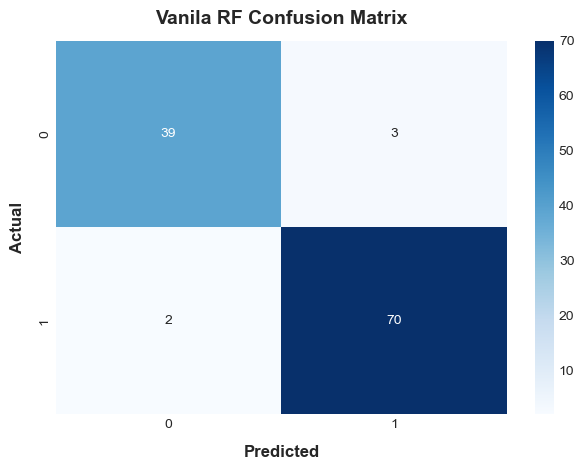

In [24]:
# Check Confusion Matrix
vanilla_matrix3 = confusion_matrix(y_test, y_pred)
print("Random Forest Confusion Matrix:\n", confusion_matrix(y_test, y_pred), "\n")

# Visualise the confusion matrix
sns.heatmap(vanilla_matrix3, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted', fontsize=12, fontweight='semibold', labelpad=10)
plt.ylabel('Actual', fontsize=12, fontweight='semibold', labelpad=10)
plt.title('Vanila RF Confusion Matrix', fontsize=14, fontweight='semibold', pad=12)

plt.tight_layout()
plt.show()

*Observation:*

- Both models found the same number of benign and malignant cases in this test. But Random Forest is the safer bet long-term, because it reduces the risk of sudden drops in performance when new data comes in.

Something to remember is that; while they may have the same results for the confusion matrix, this is more a coincidence than it is a rule.

Here's why:
- Decision Tree trains a single tree which is prone to overfitting. Its performance can swing depending on the split of the data. Sometimes it will do better, sometimes worse.
- Random Forest is an ensemble of many trees, averaging their votes. This makes it more stable and generalizable across different splits and future data.

ROC-AUC CURVE ANALYSIS


AUC: 0.991



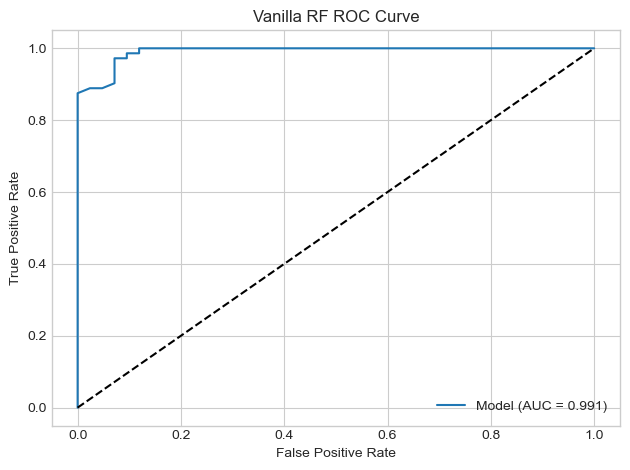

In [25]:
# Predict probabilities for the positive class
y_pred_proba = vanilla_rf.predict_proba(X_test)[:, 1]

# Compute AUC
auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC: {auc:.3f}")
print()

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f"Model (AUC = {auc:.3f})")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Vanilla RF ROC Curve")
plt.legend()
plt.tight_layout()
plt.show()

Let's check Random Forest's Classification Report

In [26]:
# Classification report
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred))

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.93      0.94        42
           1       0.96      0.97      0.97        72

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



*Interpretation:*

Benign tumors (Class 0):
- 93% recall: It correctly catches 39 out of 42 benign tumors.
- 95% precision: When it predicts benign, it’s almost always right.
- F1 = 0.94: A strong balance between catching benign cases and not over-calling them.

Malignant tumors (Class 1):
- 97% recall: It identifies 70 out of 72 malignant tumors. Very few are missed.
- 96% precision: When the model predicts malignant, it’s nearly always correct.
- F1 = 0.97: Exceptional reliability in detecting malignancy.

Overall accuracy: 96% across all patients, meaning the model gets almost everyone right.

#### VANILLA XGBOOST

In [27]:
# Instantiate model for binary classification
vanilla_boost = XGBClassifier(
    objective='binary:logistic', # For binary tasks. Multiclass tasks, uses 'multi:softmax' or 'multi:softprob'
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

# Fit model
vanilla_boost.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [28]:
# Predict
y_pred = vanilla_boost.predict(X_test)

# Training accuracy
train_accuracy = vanilla_boost.score(X_train, y_train) * 100

# Test accuracy
test_accuracy = accuracy_score(y_test, y_pred) * 100

# Display
print(f"Training Accuracy: {train_accuracy:.2f}%")
print(f"Test Accuracy:     {test_accuracy:.2f}%")

Training Accuracy: 100.00%
Test Accuracy:     94.74%


Also overfit but generalises well. Negligible difference with Random Forest. Better than Decision Trees.

Confusion Matrix:
 [[38  4]
 [ 2 70]]



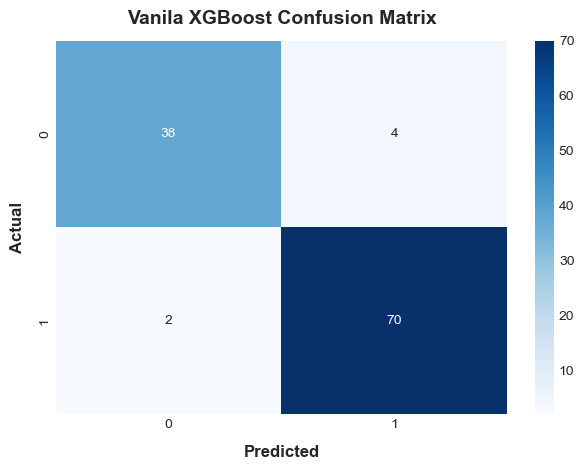

In [29]:
# Check Confusion Matrix
vanilla_matrix2 = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print()

# Visualise the confusion matrix
sns.heatmap(vanilla_matrix2, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted', fontsize=12, fontweight='semibold', labelpad=10)
plt.ylabel('Actual', fontsize=12, fontweight='semibold', labelpad=10)
plt.title('Vanila XGBoost Confusion Matrix', fontsize=14, fontweight='semibold', pad=12)
plt.tight_layout()
plt.show()

Benign tumors (Class 0):
- 38 correctly identified as benign.
- 4 misclassified as malignant (false alarms).

Malignant tumors (Class 1):
- 70 correctly identified as malignant.
- 2 missed, predicted as benign (false negatives).

XGBoost is highly reliable at detecting malignant tumors than the rest.

ROC-AUC Curve analysis to check it's learning rate.

AUC: 0.990



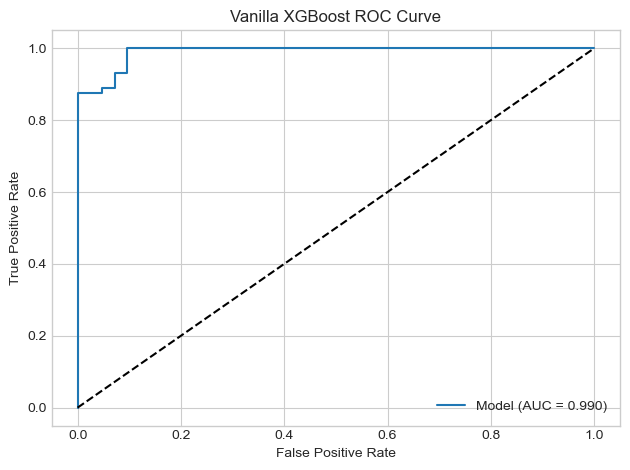

In [30]:
# Predict probabilities for the positive class
y_pred_proba = vanilla_boost.predict_proba(X_test)[:, 1]

# Compute AUC
auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC: {auc:.3f}")
print()

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f"Model (AUC = {auc:.3f})")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Vanilla XGBoost ROC Curve")
plt.legend()
plt.tight_layout()
plt.show()

In [31]:
# Classification report
print("Vanilla XGBoost Classification Report:\n", classification_report(y_test, y_pred))

Vanilla XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.90      0.93        42
           1       0.95      0.97      0.96        72

    accuracy                           0.95       114
   macro avg       0.95      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114



*Interpretation:*

Benign tumors (Class 0):
- 90% Recall: The model correctly identifies 38 out of 42 benign cases. A few benign cases (10%) are misclassified as malignant.
- 95% Precision: When it predicts benign, it’s almost always right.

Malignant tumors (Class 1):
- 97% Recall: The model detects 70 out of 72 malignant tumors, missing only 2.
- 95% Precision: When it predicts malignant, it’s almost always correct, with only a few false alarms.

Overall accuracy: 95%. Out of 114 patients, the model got 108 right.

## DEALING WITH CLASS IMBALANCE

To address the imbalance in our target, we apply two approaches:

1. **Class Weights:** Training models with adjusted class weights to penalize misclassification of the minority class.

2. **SMOTE (Synthetic Minority Oversampling Technique):** Generating synthetic samples of the minority class to create a more balanced training dataset.

We will then compare model performance under both approaches.

### 1. USING CLASS WEIGHTS

#### DECISION TREE

In [32]:
# Instantiate model with class weights
Weighted_DT = DecisionTreeClassifier(class_weight="balanced", random_state=42)

# Fit the model
Weighted_DT.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', random_state=42)

In [33]:
# Predict
y_pred = Weighted_DT.predict(X_test)

# Training accuracy
train_accuracy = Weighted_DT.score(X_train, y_train) * 100

# Test accuracy
test_accuracy = accuracy_score(y_test, y_pred) * 100

# Display neatly
print(f"Training Accuracy: {train_accuracy:.2f}%")
print(f"Test Accuracy:     {test_accuracy:.2f}%")

Training Accuracy: 100.00%
Test Accuracy:     93.86%


Overfitting is still a pain point.

Weighted Class Decision Tree Confusion Matrix:
 [[39  3]
 [ 4 68]] 



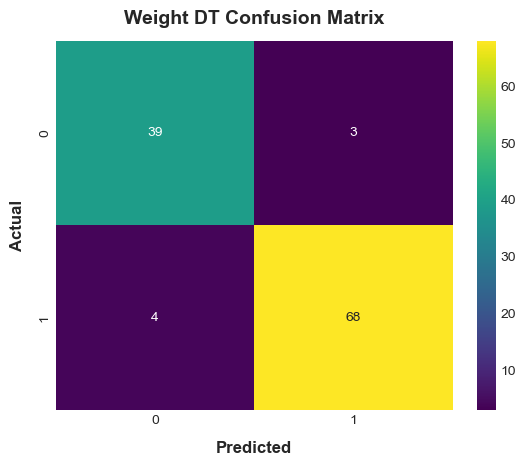

<Figure size 640x480 with 0 Axes>

In [34]:
# Check Confusion Matrix
weighted_matrix1 = confusion_matrix(y_test, y_pred)
print("Weighted Class Decision Tree Confusion Matrix:\n", confusion_matrix(y_test, y_pred), "\n")

# Visualise the confusion matrix
sns.heatmap(weighted_matrix1, annot=True, fmt='d', cmap='viridis')
plt.xlabel('Predicted', fontsize=12, fontweight='semibold', labelpad=10)
plt.ylabel('Actual', fontsize=12, fontweight='semibold', labelpad=10)
plt.title('Weight DT Confusion Matrix', fontsize=14, fontweight='semibold', pad=12)
plt.show()

plt.tight_layout()
plt.show()

*Observation:*

No notable difference from it's vanilla version.

AUC: 0.937



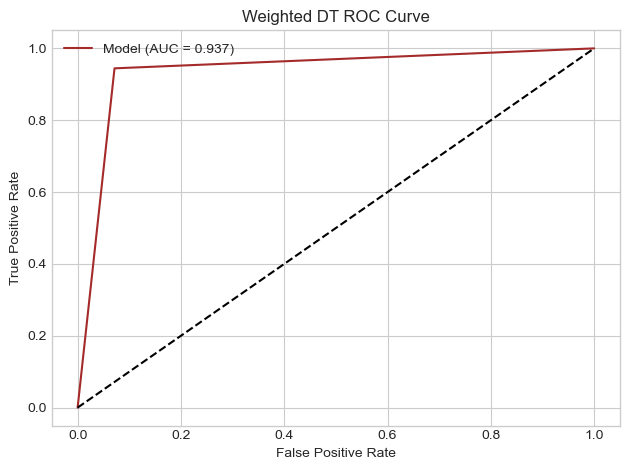

In [35]:
# Predict probabilities for the positive class
y_pred_proba = Weighted_DT.predict_proba(X_test)[:, 1]

# Compute AUC
auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC: {auc:.3f}")
print()

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f"Model (AUC = {auc:.3f})", color='brown')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Weighted DT ROC Curve")
plt.legend()
plt.tight_layout()
plt.show()

Check classification report for more insights

In [36]:
# Classification report
print("Weighted Class DT Classification Report:\n", classification_report(y_test, y_pred))

Weighted Class DT Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.93      0.92        42
           1       0.96      0.94      0.95        72

    accuracy                           0.94       114
   macro avg       0.93      0.94      0.93       114
weighted avg       0.94      0.94      0.94       114



*Interpretation:*

Compared to its vanilla counterpart:

- The weighted version outperforms vanilla across the board. It is more accurate overall (91% vs. 89%), and both benign and malignant detection improve slightly.

- The biggest gain is in precision: when it says “malignant,” it is right 96% of the time (up from 94%). That reduces unnecessary stress for patients flagged incorrectly.

- More importantly, malignant recall improved from 88% to 90%, meaning 2 fewer cancers are missed.

#### RANDOM FORESTS

In [37]:
# Instantiate model with class weights
Weighted_RF = RandomForestClassifier(
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

# Fit the model
Weighted_RF.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)

In [38]:
# Predict
y_pred = Weighted_RF.predict(X_test)

# Training accuracy
train_accuracy = Weighted_RF.score(X_train, y_train) * 100

# Test accuracy
test_accuracy = accuracy_score(y_test, y_pred) * 100

# Display
print(f"Training Accuracy: {train_accuracy:.2f}%")
print(f"Test Accuracy:     {test_accuracy:.2f}%")

Training Accuracy: 100.00%
Test Accuracy:     93.86%


Overfitting persists.

Weightd Class Random Forest Confusion Matrix:
 [[39  3]
 [ 4 68]] 



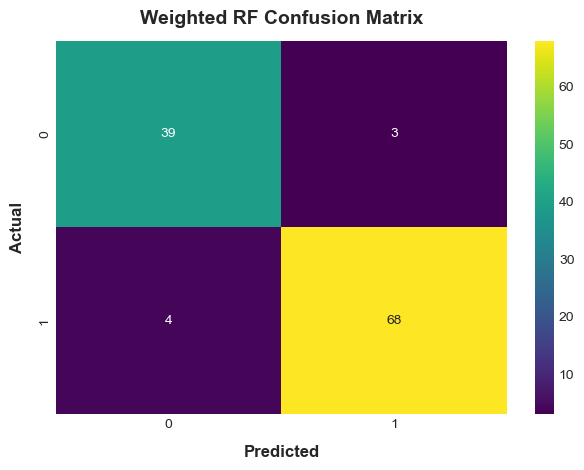

In [39]:
# Check Confusion Matrix
weighted_matrix2 = confusion_matrix(y_test, y_pred)
print("Weightd Class Random Forest Confusion Matrix:\n", confusion_matrix(y_test, y_pred), "\n")

# Visualise the confusion matrix
sns.heatmap(weighted_matrix2, annot=True, fmt='d', cmap='viridis')
plt.xlabel('Predicted', fontsize=12, fontweight='semibold', labelpad=10)
plt.ylabel('Actual', fontsize=12, fontweight='semibold', labelpad=10)
plt.title('Weighted RF Confusion Matrix', fontsize=14, fontweight='semibold', pad=12)

plt.tight_layout()
plt.show()

Same as its vanilla counterpart as well.

ROC-AUC CURVE ANALYSIS

AUC: 0.993



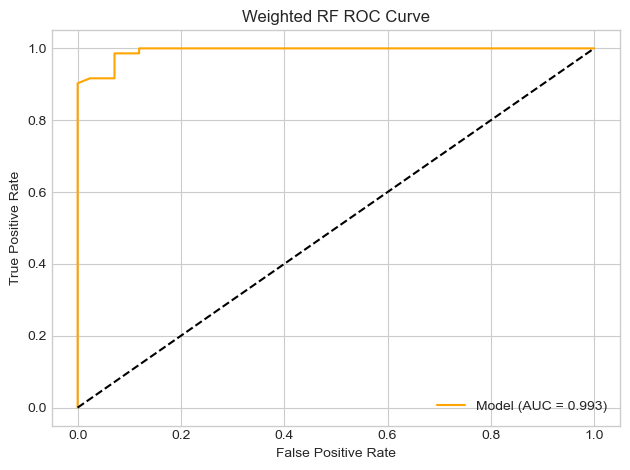

In [40]:
# Predict probabilities for the positive class
y_pred_proba = Weighted_RF.predict_proba(X_test)[:, 1]

# Compute AUC
auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC: {auc:.3f}")
print()

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f"Model (AUC = {auc:.3f})", color='orange')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Weighted RF ROC Curve")
plt.legend()
plt.tight_layout()
plt.show()

Deeper check into the model's performance in the classification report.

In [41]:
# Classification report
print("Weighted Class Random Forest Classification Report:\n", classification_report(y_test, y_pred))

Weighted Class Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.93      0.92        42
           1       0.96      0.94      0.95        72

    accuracy                           0.94       114
   macro avg       0.93      0.94      0.93       114
weighted avg       0.94      0.94      0.94       114



*Observation:*

Compared to the vanilla version:

- Accuracy jumped from 0.91 to 0.94.
- Class 0 saw the biggest boost in precision (0.86 to 0.91) and F1 (0.89 to 0.92).
- Class 1 also improved slightly in recall (0.90 to 0.94) and F1 (0.93 to 0.95).
- Weighted averaging helped the minority class (0) without hurting majority (1).

#### WEIGHTED CLASS XGBOOST

In [42]:
# Get unique classes
classes = np.unique(y_train)

# Compute balanced class weights
class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
weight_dict = dict(zip(classes, class_weights))

# Map weights to training samples
sample_weights = np.array([weight_dict[label] for label in y_train])

# Instantiate XGBClassifier for multiclass
Weighted_XGB = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1
)

# Fit with sample weights
Weighted_XGB.fit(X_train, y_train, sample_weight=sample_weights)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, ...)

In [43]:
# Predict
y_pred = Weighted_XGB.predict(X_test)

# Training accuracy
train_accuracy = Weighted_XGB.score(X_train, y_train) * 100

# Test accuracy
test_accuracy = accuracy_score(y_test, y_pred) * 100

# Display neatly
print(f"Training Accuracy: {train_accuracy:.2f}%")
print(f"Test Accuracy:     {test_accuracy:.2f}%")

Training Accuracy: 100.00%
Test Accuracy:     95.61%


Weighted Class XGBoost Confusion Matrix:
 [[38  4]
 [ 1 71]] 



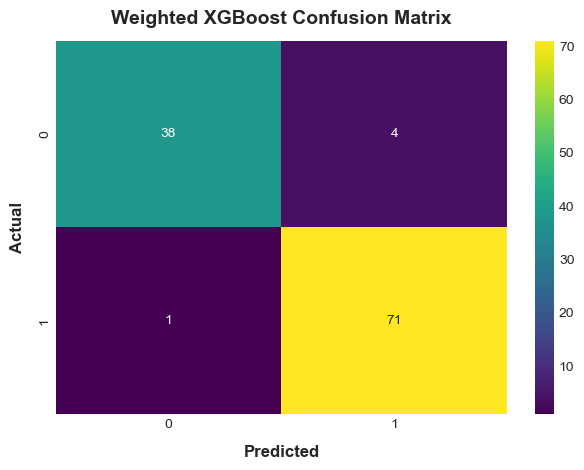

In [44]:
# Check Confusion Matrix
weighted_matrix3 = confusion_matrix(y_test, y_pred)
print("Weighted Class XGBoost Confusion Matrix:\n", confusion_matrix(y_test, y_pred), "\n")

# Visualise the confusion matrix
sns.heatmap(weighted_matrix3, annot=True, fmt='d', cmap='viridis')
plt.xlabel('Predicted', fontsize=12, fontweight='semibold', labelpad=10)
plt.ylabel('Actual', fontsize=12, fontweight='semibold', labelpad=10)
plt.title('Weighted XGBoost Confusion Matrix', fontsize=14, fontweight='semibold', pad=12)

plt.tight_layout()
plt.show()

*Observation:*

Displays the same results as Decision Trees and Random Forest.

ROC-AUC CURVE ANALYSIS

AUC: 0.994 



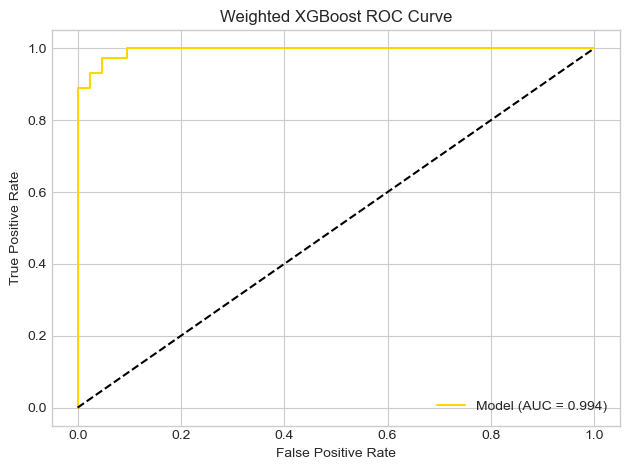

In [45]:
# Predict probabilities for the positive class
y_pred_proba = Weighted_XGB.predict_proba(X_test)[:, 1]

# Compute AUC
auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC: {auc:.3f}", "\n")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f"Model (AUC = {auc:.3f})", color='gold')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Weighted XGBoost ROC Curve")
plt.legend()
plt.tight_layout()
plt.show()

Classification Report

In [46]:
# Classification report
print("Weighted XGBoost Classification Report:\n", classification_report(y_test, y_pred))

Weighted XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.90      0.94        42
           1       0.95      0.99      0.97        72

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



*Interpretation:*

Compared to the Vanilla Version:

- Overall accuracy improved slightly (0.95 to 0.96).
- Malignant class (1) recall increased from 0.97 to 0.99, meaning almost no malignant tumors are missed.
- Benign precision improved (0.95 to 0.97), so fewer false alarms for healthy patients.
- The weighted approach fine-tunes the model for class imbalance, enhancing detection of the critical malignant class while maintaining strong performance on benign cases.

### 2. USING SMOTE

SMOTE (Synthetic Minority Oversampling Technique) addresses class imbalance by generating synthetic samples for the minority class.

This resampling process helps balance the class distribution, ensuring that all classes are more equally represented during training.

In [47]:
# Prepare the data by:
# Apply SMOTE on training data
smote = SMOTE(random_state=42, sampling_strategy='auto')
x_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Check new class distribution
print("Before SMOTE:\n", pd.Series(y_train).value_counts(normalize=True))
print("\nAfter SMOTE:\n", pd.Series(y_train_res).value_counts(normalize=True))

Before SMOTE:
 target
1    0.626374
0    0.373626
Name: proportion, dtype: float64

After SMOTE:
 target
1    0.5
0    0.5
Name: proportion, dtype: float64


#### DECISION TREES WITH SMOTE

In [48]:
# Initialize Decision Tree
smote_dt = DecisionTreeClassifier(random_state=42)

# Fit on SMOTE-resampled data
smote_dt.fit(x_train_res, y_train_res)

DecisionTreeClassifier(random_state=42)

In [49]:
# Predict
y_pred = smote_dt.predict(X_test)

# Evaluate model
train_accuracy = smote_dt.score(x_train_res, y_train_res) * 100
test_accuracy = accuracy_score(y_test, y_pred) * 100

print(f"Training Accuracy: {train_accuracy:.2f}%")
print(f"Test Accuracy:     {test_accuracy:.2f}%")

Training Accuracy: 100.00%
Test Accuracy:     92.98%


Overfitting remains an issue.

SMOTE Decision Tree Confusion Matrix:
 [[39  3]
 [ 5 67]]



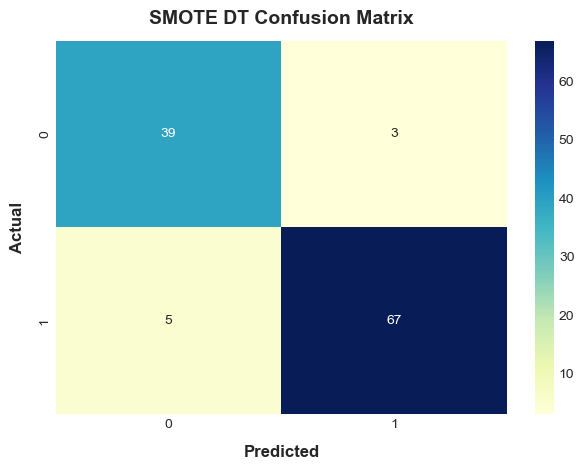

In [50]:
# Check confusion matrix
smote_matrix1 = confusion_matrix(y_test, y_pred)
print("SMOTE Decision Tree Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print()

# Visualise the confusion matrix
sns.heatmap(smote_matrix1, annot=True, fmt='d', cmap='YlGnBu')
plt.xlabel('Predicted', fontsize=12, fontweight='semibold', labelpad=10)
plt.ylabel('Actual', fontsize=12, fontweight='semibold', labelpad=10)
plt.title('SMOTE DT Confusion Matrix', fontsize=14, fontweight='semibold', pad=12)

plt.tight_layout()
plt.show()

*Interpretation:*

- Out of 42 benign cases, the model correctly classifies 93%, with 7% false alarms.
- Out of 72 malignant cases, it correctly detects 93%, missing 5 tumors.

AUC: 0.930 



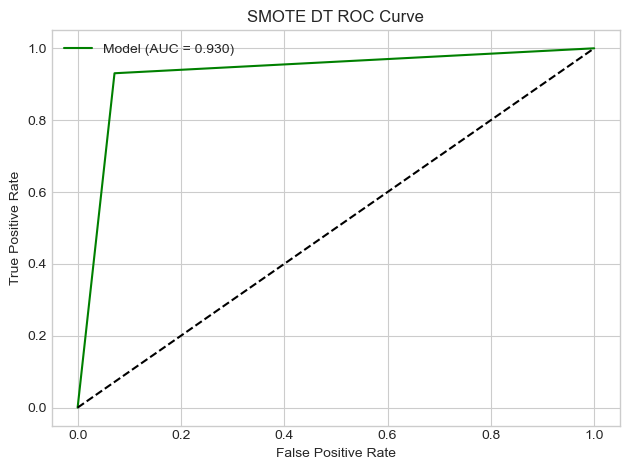

In [51]:
# Predict probabilities for the positive class
y_pred_proba = smote_dt.predict_proba(X_test)[:, 1]

# Compute AUC
auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC: {auc:.3f}", "\n")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f"Model (AUC = {auc:.3f})", color='g')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("SMOTE DT ROC Curve")
plt.legend()
plt.tight_layout()
plt.show()

In [52]:
# Classification Report
print("SMOTE DT Classification Report:\n", classification_report(y_test, y_pred))

SMOTE DT Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.93      0.91        42
           1       0.96      0.93      0.94        72

    accuracy                           0.93       114
   macro avg       0.92      0.93      0.93       114
weighted avg       0.93      0.93      0.93       114



*Interpretation:*

Benign tumors (Class 0):
- 89% Precision: When the model predicts benign, it is correct 89% of the time.
- 93% Recall: It correctly identifies 93% of actual benign tumors.
- 91% F1: Strong balance between precision and recall for benign cases.

Malignant tumors (Class 1):
- 96% Precision: Very few false positives when predicting malignancy.
- 93% Recall: It correctly identifies 93% of malignant tumors.
- 94% F1: Excellent balance for the critical malignant class.

The key things to note here are:

- 93% Overall Accuracy: The model correctly predicts 106 out of 114 cases.
- 93% Macro & Weighted F1: Balanced performance across both classes.

#### SMOTE RANDOM FORESTS

In [53]:
#instantiate the model
smote_rf = RandomForestClassifier(random_state=42)

#train the model
smote_rf.fit(x_train_res, y_train_res)

RandomForestClassifier(random_state=42)

In [54]:
# Predict
y_pred = smote_rf.predict(X_test)

# Evaluate model
train_score = smote_rf.score(x_train_res, y_train_res) * 100
test_score = accuracy_score(y_test, y_pred) * 100

print(f"Training Accuracy: {train_score:.2f}%")
print(f"Test Accuracy:     {test_score:.2f}%")

Training Accuracy: 100.00%
Test Accuracy:     92.98%


SMOTE Random Forest Confusion Matrix:
 [[39  3]
 [ 5 67]]



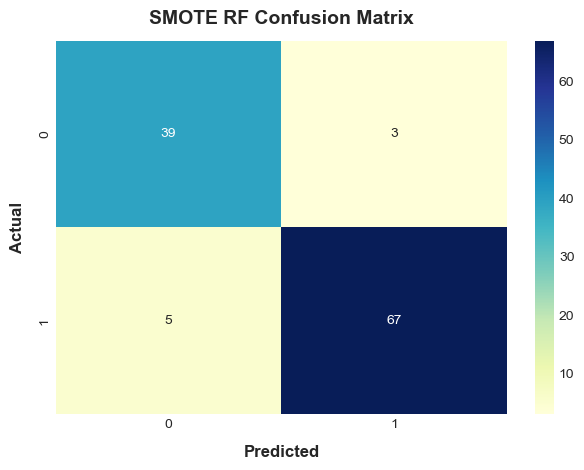

In [55]:
# Check confusion matrix
smote_matrix2 = confusion_matrix(y_test, y_pred)
print("SMOTE Random Forest Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print()

# Visualise the confusion matrix
sns.heatmap(smote_matrix2, annot=True, fmt='d', cmap='YlGnBu')
plt.xlabel('Predicted', fontsize=12, fontweight='semibold', labelpad=10)
plt.ylabel('Actual', fontsize=12, fontweight='semibold', labelpad=10)
plt.title('SMOTE RF Confusion Matrix', fontsize=14, fontweight='semibold', pad=12)

plt.tight_layout()
plt.show()

*Observation:*

- Out of 42 benign cases, the model correctly classifies 93%, with 7% false alarms.
- Out of 72 malignant cases, it correctly detects 93%, missing 5 tumors.

ROC-AUC CURVE ANALYSIS

AUC: 0.994 



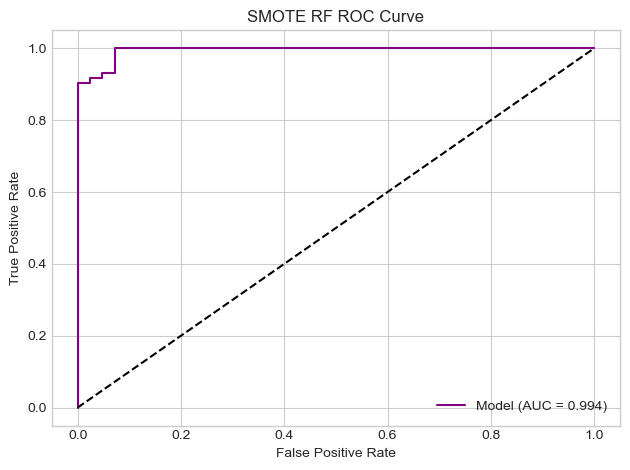

In [56]:
# Predict probabilities for the positive class
y_pred_proba = smote_rf.predict_proba(X_test)[:, 1]

# Compute AUC
auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC: {auc:.3f}", "\n")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f"Model (AUC = {auc:.3f})", color='purple')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("SMOTE RF ROC Curve")
plt.legend()
plt.tight_layout()
plt.show()

In [57]:
# Check the classification report
print("SMOTE RT Classification Report:\n", classification_report(y_test, y_pred))

SMOTE RT Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.93      0.91        42
           1       0.96      0.93      0.94        72

    accuracy                           0.93       114
   macro avg       0.92      0.93      0.93       114
weighted avg       0.93      0.93      0.93       114



*Interpretation:*

Just like SMOTE Random Forest:

Benign tumors (Class 0):
- Out of 42 benign cases, the model correctly identifies 39.
- Only 3 healthy tumors are mistakenly flagged as malignant, so unnecessary follow-ups are minimal.
- Overall, when it predicts benign, it is right almost 9 out of 10 times.

Malignant tumors (Class 1):
- Out of 72 malignant cases, the model correctly detects 67, missing 5 tumors.
- When it predicts malignancy, it is right 96% of the time, meaning very few false alarms.

Overall:
- The model correctly predicts 106 out of 114 tumors; an accuracy of 93%.
- It balances performance between both benign and malignant tumors, so neither class is neglected.

#### SMOTE XGBOOST

In [58]:
# Instantiate binary XGBoost
smote_xgb = XGBClassifier(
    objective="binary:logistic",
    random_state=42,
    n_jobs=-1,
    use_label_encoder=False,
    eval_metric="logloss"
)

# Fit on SMOTE-resampled training data
smote_xgb.fit(x_train_res, y_train_res)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, ...)

In [59]:
# Predict
y_pred = smote_xgb.predict(X_test)

# Evaluate model
train_score = smote_xgb.score(x_train_res, y_train_res) * 100
test_score = accuracy_score(y_test, y_pred) * 100

print(f"Training Accuracy: {train_score:.2f}%")
print(f"Test Accuracy:     {test_score:.2f}%")

Training Accuracy: 100.00%
Test Accuracy:     94.74%


SMOTE XGBoost Confusion Matrix:
 [[38  4]
 [ 2 70]]



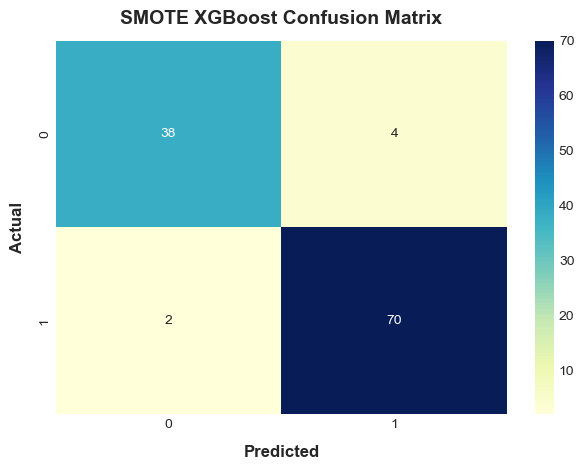

In [60]:
# Check confusion matrix
smote_matrix3 = confusion_matrix(y_test, y_pred)
print("SMOTE XGBoost Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print()

# Visualise the confusion matrix
sns.heatmap(smote_matrix3, annot=True, fmt='d', cmap='YlGnBu')
plt.xlabel('Predicted', fontsize=12, fontweight='semibold', labelpad=10)
plt.ylabel('Actual', fontsize=12, fontweight='semibold', labelpad=10)
plt.title('SMOTE XGBoost Confusion Matrix', fontsize=14, fontweight='semibold', pad=12)

plt.tight_layout()
plt.show()

AUC: 0.995 



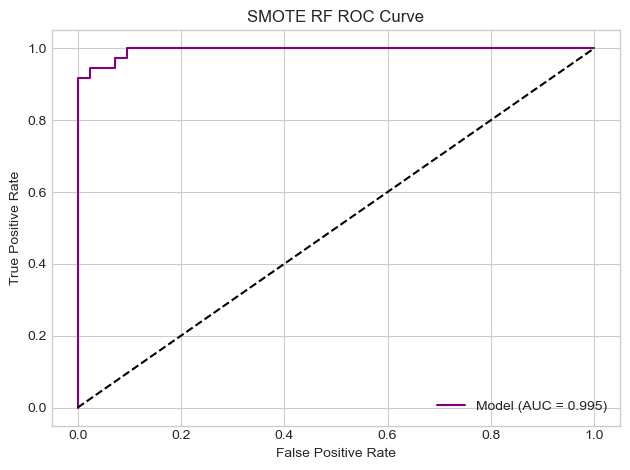

In [61]:
# Predict probabilities for the positive class
y_pred_proba = smote_xgb.predict_proba(X_test)[:, 1]

# Compute AUC
auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC: {auc:.3f}", "\n")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f"Model (AUC = {auc:.3f})", color='purple')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("SMOTE RF ROC Curve")
plt.legend()
plt.tight_layout()
plt.show()

In [62]:
# Check classification report
print("SMOTE XGBoost Classification Report:\n", classification_report(y_test, y_pred))

SMOTE XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.90      0.93        42
           1       0.95      0.97      0.96        72

    accuracy                           0.95       114
   macro avg       0.95      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114



## MODEL EVALUATION AND CLASS IMBALANCE HANDLING

### Performance Summary

| Model | Variant | Accuracy | Precision (Class 0) | Recall (Class 0) | F1 (Class 0) | Precision (Class 1) | Recall (Class 1) | F1 (Class 1) |
|-------|---------|----------|---------------------|------------------|--------------|---------------------|------------------|--------------|
| Decision Tree | Vanilla  | 0.90 | 0.83 | 0.93 | 0.88 | 0.96 | 0.89 | 0.92 |
|               | Weighted | 0.94 | 0.91 | 0.93 | 0.92 | 0.96 | 0.94 | 0.95 |
|               | SMOTE    | 0.93 | 0.89 | 0.93 | 0.91 | 0.96 | 0.93 | 0.94 |
| Random Forest | Vanilla  | 0.96 | 0.95 | 0.93 | 0.94 | 0.96 | 0.97 | 0.97 |
|               | Weighted | 0.94 | 0.91 | 0.93 | 0.92 | 0.96 | 0.94 | 0.95 |
|               | SMOTE    | 0.93 | 0.89 | 0.93 | 0.91 | 0.96 | 0.93 | 0.94 |
| XGBoost       | Vanilla  | 0.95 | 0.95 | 0.90 | 0.93 | 0.95 | 0.97 | 0.96 |
|               | Weighted | 0.96 | 0.97 | 0.90 | 0.94 | 0.95 | 0.99 | 0.97 |
|               | SMOTE    | 0.95 | 0.95 | 0.90 | 0.93 | 0.95 | 0.97 | 0.96 |

### Observations

- **Highest accuracy:** Random Forest (Vanilla, **95.61%**) and XGBoost (Weighted, **95.61%**).  
- **Best balanced detection:** XGBoost (Weighted) with **Class 1 recall = 0.99** while maintaining strong performance on Class 0.  
- **Decision Trees:** Improved significantly with class weighting (from 90% to 94%), but still less robust than ensemble methods.  
- **Random Forest:** Strong baseline, but weighting/SMOTE slightly reduced accuracy; suggests it already handled imbalance well.  
- **XGBoost:** Stable across all variants, with **weighted classes clearly the best balance of accuracy and fairness**.  

### CLASS IMBALANCE HANDLING SUMMARY

| Model         | Best Method       | Accuracy | Class 1 Recall |
|---------------|------------------|----------|----------------|
| Decision Tree | Weighted Classes | 0.94     | 0.94 |
| Random Forest | Vanilla          | 0.96     | 0.97 |
| XGBoost       | Weighted Classes | 0.96     | 0.99 |

**Key Takeaways:**  
- **XGBoost (Weighted)**: Best for maximizing recall on the positive class while keeping high overall accuracy.  
- **Random Forest (Vanilla)**: Most reliable for strong overall performance without imbalance interventions.  
- **Decision Tree (Weighted)**: Improved, but less competitive compared to ensemble methods.  

### NEXT STEPS

Focus on **hyperparameter tuning** for:  
- **XGBoost (Weighted)**: Use early stopping to avoid overfitting.  
- **Random Forest (Vanilla)**: Consider limiting tree depth to reduce variance.  
- **Decision Tree (Weighted)**: Apply pruning strategies to mitigate overfitting.  

# HYPERPARAMETER TUNING

This process involves tuning models by selecting improved parameters to enhance the training of both the weighted-class and SMOTE-based approaches.

We will perform hyperparameter tuning on both the Random Forest and XGBoost models using techniques such as GridSearchCV and RandomizedSearchCV to identify the best parameter configurations and optimize model performance.

### 1. GRIDSEARCHCV

#### WEIGHTED XGBOOST WITH GRIDSEARCHCV

In [63]:
# Calculate sample weights
sample_weights = compute_sample_weight(class_weight="balanced", y=y_train)

# Instantiate XGBoost binary classifier
xgb_model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1
)

# Hyperparameter grid
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# GridSearchCV
grid_search_xgb = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1
)

# Fit on weighted training data
grid_search_xgb.fit(X_train, y_train, sample_weight=sample_weights)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraint...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=-1, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [3, 5, 7, 10],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.8, 1.0]},
             scoring='accuracy', verbose=1)

In [64]:
# Check best parameters and score
print("Best Parameters:", grid_search_xgb.best_params_)

Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}


In [65]:
# Create the model with the best parameters
Grid_XGB = XGBClassifier(
    **grid_search_xgb.best_params_,
    random_state=42,
    n_jobs=-1,
    objective="binary:logistic",
    eval_metric="logloss",
    use_label_encoder=False
)

# Fit on sampled weights
Grid_XGB.fit(X_train, y_train, sample_weight=sample_weights)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=-1,
              num_parallel_tree=None, ...)

In [66]:
# Predict
y_pred = Grid_XGB.predict(X_test)

# Check training score
train_accuracy = Grid_XGB.score(X_train, y_train) * 100

# Check test accuracy
test_accuracy = accuracy_score(y_test, y_pred) * 100

# Display
print(f"Training Accuracy: {train_accuracy:.2f}%")
print(f"Test Accuracy:     {test_accuracy:.2f}%")

Training Accuracy: 100.00%
Test Accuracy:     94.74%


Weighted XGBoost with GridSearchCV Confusion Matrix:
 [[38  4]
 [ 2 70]]



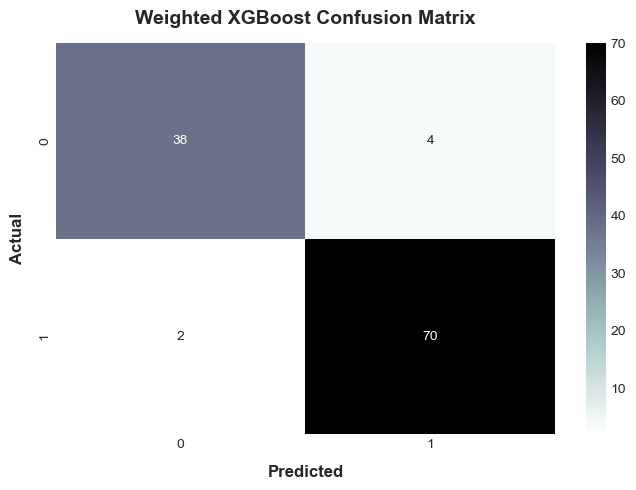

In [67]:
# Compute confusion matrix
conf_gridcv = confusion_matrix(y_test, y_pred)
print("Weighted XGBoost with GridSearchCV Confusion Matrix:\n", conf_gridcv)
print()

# Plot
plt.figure(figsize=(7,5))
sns.heatmap(conf_gridcv, annot=True, fmt="d", cmap="bone_r", cbar=True)
plt.title("Weighted XGBoost Confusion Matrix", fontsize=14, fontweight='semibold', pad=14)
plt.xlabel("Predicted", fontsize=12, fontweight='semibold', labelpad=10)
plt.ylabel("Actual", fontsize=12, fontweight='semibold', labelpad=10)

plt.tight_layout()
plt.show()

*Observation:*

Benign tumors (Class 0):
- Out of 42 benign cases, the model correctly identifies 38.
- 4 benign tumors are mistakenly flagged as malignant, leading to some extra follow-up tests.

Malignant tumors (Class 1):
- Out of 72 malignant cases, the model correctly detects 70, missing only 2 tumors.
- Very few malignant cases are overlooked, which is crucial in a clinical setting.

AUC: 0.992



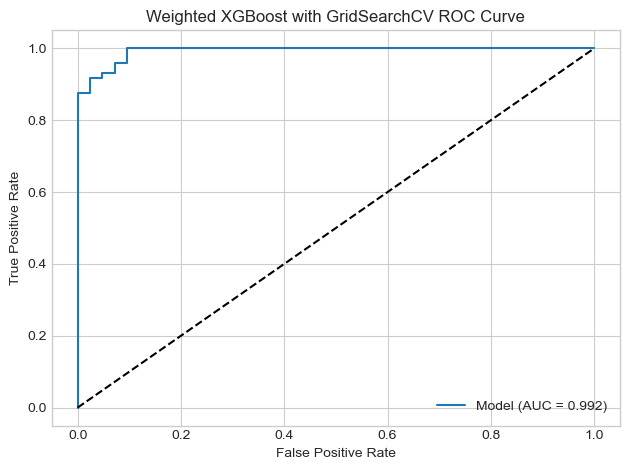

In [68]:
# Predict probabilities for the positive class
y_pred_proba = Grid_XGB.predict_proba(X_test)[:, 1]

# Compute AUC
auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC: {auc:.3f}")
print()

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f"Model (AUC = {auc:.3f})")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Weighted XGBoost with GridSearchCV ROC Curve")
plt.legend()
plt.tight_layout()
plt.show()

In [69]:
# Check classification report
print("Weighted XGBoost with GridSearchCV Classification Report:\n", classification_report(y_test, y_pred))

Weighted XGBoost with GridSearchCV Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.90      0.93        42
           1       0.95      0.97      0.96        72

    accuracy                           0.95       114
   macro avg       0.95      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114



*Interpretation:*

Benign tumors (Class 0):
- Out of 42 benign cases, the model correctly identifies 38.
- 4 benign tumors are incorrectly flagged as malignant, meaning a small number of healthy patients may undergo extra follow-up.
- When the model predicts benign, it is right 95% of the time.

Malignant tumors (Class 1):
- Out of 72 malignant cases, it correctly detects 70, missing only 2 tumors.
- When it predicts malignant, it is correct 95% of the time, ensuring very few cancers are missed.

Overall:
- The model achieves 95% accuracy, correctly classifying 108 out of 114 tumors.
- F1-scores (0.93 for benign, 0.96 for malignant) show strong balance between precision and recall for both classes.

#### VANILLA RANDOM FOREST WITH GRIDSEARCH

In [70]:
# Instantiate untrained random forest classifier
new_rf = RandomForestClassifier()

# Parameters
param_grid = {"criterion": ["gini", "entropy"],
              "max_depth": [3, 5, 7, 8, None],
              "min_samples_split":[2, 5, 8, 10]
             }

#Instantiate gridsearch
grid_search = GridSearchCV(
                    estimator=new_rf,
                    param_grid=param_grid,
                    cv=5,
                    scoring="accuracy"
)

# Fit model
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 7, 8, None],
                         'min_samples_split': [2, 5, 8, 10]},
             scoring='accuracy')

In [71]:
# Get the best parameters
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_split': 5}


In [72]:
# Create the model with the best parameters
vanilla_RF = RandomForestClassifier(
    **grid_search.best_params_,
    n_jobs=-1,
    random_state=42
)

# Train the model
vanilla_RF.fit(X_train, y_train)

RandomForestClassifier(min_samples_split=5, n_jobs=-1, random_state=42)

In [73]:
# Predict
y_pred = vanilla_RF.predict(X_test)

# Check training score
train_accuracy = vanilla_RF.score(X_train, y_train) * 100

# Check test accuracy
test_accuracy = accuracy_score(y_test, y_pred) * 100

# Display
print(f"Training Accuracy: {train_accuracy:.2f}%")
print(f"Test Accuracy:     {test_accuracy:.2f}%")

Training Accuracy: 99.78%
Test Accuracy:     95.61%


Vanilla RF with GridSearchCV Confusion Matrix:
 [[39  3]
 [ 2 70]] 



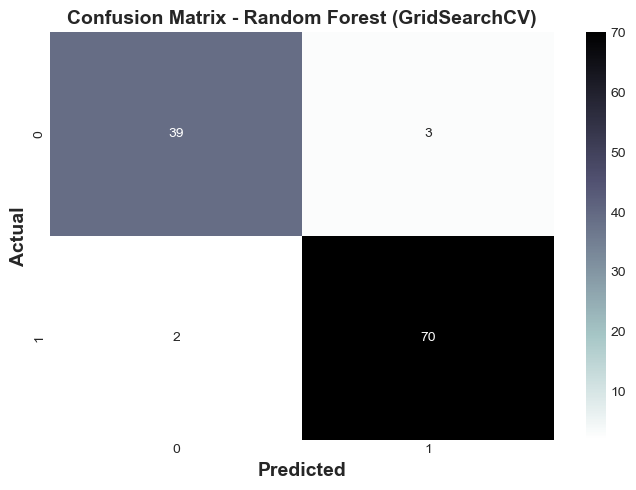

In [74]:
# Compute confusion matrix
conf_grid = confusion_matrix(y_test, y_pred)
print("Vanilla RF with GridSearchCV Confusion Matrix:\n", conf_grid, "\n")

# Plot
plt.figure(figsize=(7, 5))
sns.heatmap(
    conf_grid,
    annot=True,
    fmt="d",
    cmap="bone_r",
)
plt.title("Confusion Matrix - Random Forest (GridSearchCV)", fontsize=14, fontweight='semibold')
plt.xlabel("Predicted", fontsize=14, fontweight='semibold')
plt.ylabel("Actual", fontsize=14, fontweight='semibold')

plt.tight_layout()
plt.show()

*Observation:*

- Slightly higher number of missed malignant cases compared to weighted or XGBoost models.

AUC: 0.994



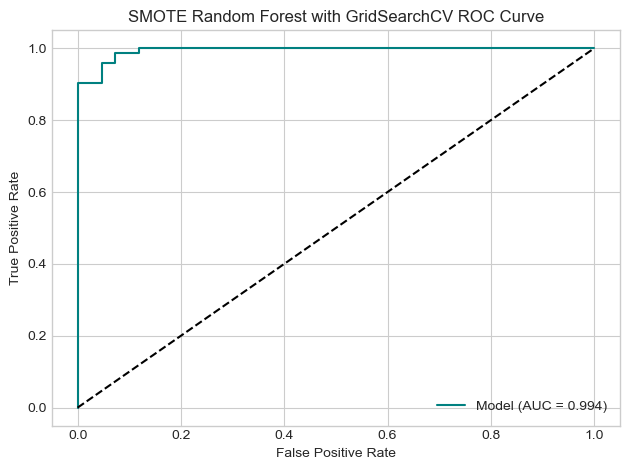

In [75]:
# Predict probabilities for the positive class
y_pred_proba = vanilla_RF.predict_proba(X_test)[:, 1]

# Compute AUC
auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC: {auc:.3f}")
print()

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f"Model (AUC = {auc:.3f})", color='teal')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("SMOTE Random Forest with GridSearchCV ROC Curve")
plt.legend()
plt.tight_layout()
plt.show()

In [76]:
# Check classification report
print("GridSearchCV Random Forest Classification Report:\n", classification_report(y_test, y_pred))

GridSearchCV Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.93      0.94        42
           1       0.96      0.97      0.97        72

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



*Interpretation:*

Benign tumors (Class 0):
- Out of 42 benign cases, the model correctly identifies 39.
- 3 benign tumors are incorrectly flagged as malignant, meaning very few unnecessary follow-ups.
- When the model predicts benign, it is correct 95% of the time.

Malignant tumors (Class 1):
- Out of 72 malignant cases, it correctly detects 70, missing only 2 tumors.
- When it predicts malignant, it is correct 96% of the time, ensuring high reliability.

Overall:
- The model achieves 96% accuracy, correctly classifying 109 out of 114 tumors.
- F1-scores (0.94 for benign, 0.97 for malignant) show excellent balance between precision and recall for both classes.

#### PRUNED DECISION TREE USING GRIDSEARCHCV

In [77]:
# Instantiate parameter grid
param_grid = {
    'max_depth': [3, 5, 7, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'ccp_alpha': [0.0, 0.01, 0.05, 0.1]
}

# Instantiate new DT
dt = DecisionTreeClassifier(random_state=42)

# Perform GridSearchCV
grid_search = GridSearchCV(dt, param_grid, cv=5, scoring='f1_macro')

# Fit model
grid_search.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'ccp_alpha': [0.0, 0.01, 0.05, 0.1],
                         'max_depth': [3, 5, 7, None],
                         'min_samples_leaf': [1, 2, 5, 10],
                         'min_samples_split': [2, 5, 10, 20]},
             scoring='f1_macro')

In [78]:
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'ccp_alpha': 0.0, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [79]:
# Create the model with the best parameters
pruned_DT = DecisionTreeClassifier(
    **grid_search.best_params_,
    random_state=42
)

# Train the model
pruned_DT.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, random_state=42)

In [80]:
# Predict
y_pred = pruned_DT.predict(X_test)

# Check training score
train_accuracy = pruned_DT.score(X_train, y_train) * 100

# Check test accuracy
test_accuracy = accuracy_score(y_test, y_pred) * 100

# Display
print(f"Training Accuracy: {train_accuracy:.2f}%")
print(f"Test Accuracy:     {test_accuracy:.2f}%")

Training Accuracy: 99.34%
Test Accuracy:     91.23%


The model is not overfit and generalises exceptionally!

Pruned DT Using GridSearchCV Confusion Matrix:
 [[39  3]
 [ 7 65]] 



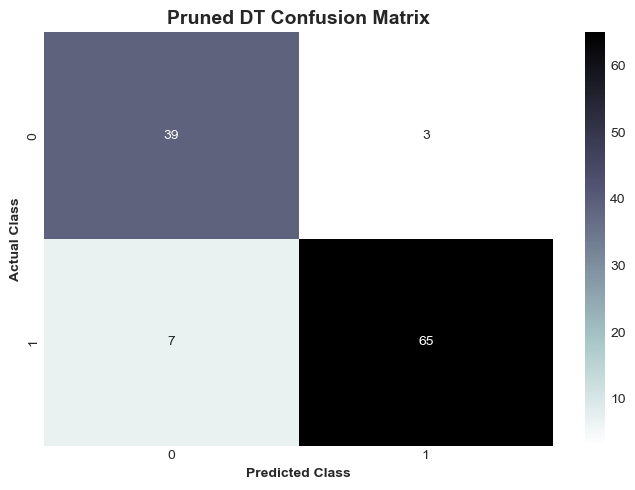

In [81]:
# Compute confusion matrix
pruned_conf= confusion_matrix(y_test, y_pred)
print("Pruned DT Using GridSearchCV Confusion Matrix:\n", pruned_conf, "\n")

# Plot
plt.figure(figsize=(7,5))
sns.heatmap(pruned_conf, annot=True, fmt="d", cmap="bone_r", cbar=True)
plt.title("Pruned DT Confusion Matrix", fontsize=14, fontweight='semibold')
plt.xlabel("Predicted Class", fontsize=10, fontweight='semibold')
plt.ylabel("Actual Class", fontsize=10, fontweight='semibold')

plt.tight_layout()
plt.show()

*Observation:*

- No observable improvement.

ROC-AUC CURVE ANALYSIS

AUC: 0.909



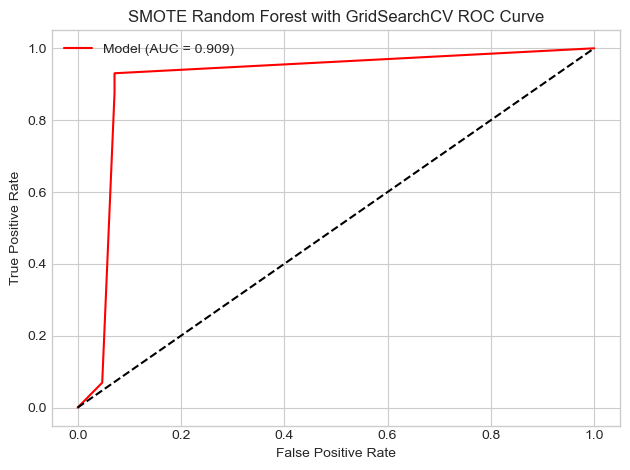

In [82]:
# Predict probabilities for the positive class
y_pred_proba = pruned_DT.predict_proba(X_test)[:, 1]

# Compute AUC
auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC: {auc:.3f}")
print()

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f"Model (AUC = {auc:.3f})", color='red')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("SMOTE Random Forest with GridSearchCV ROC Curve")
plt.legend()
plt.tight_layout()
plt.show()

In [83]:
# Check Classification Report
print("Pruned Weighted Decision Tree Classification Report:\n", classification_report(y_test, y_pred))

Pruned Weighted Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.93      0.89        42
           1       0.96      0.90      0.93        72

    accuracy                           0.91       114
   macro avg       0.90      0.92      0.91       114
weighted avg       0.92      0.91      0.91       114



*Interpretation:*

Benign tumors (Class 0):
- Out of 42 benign cases, the model correctly identifies 39.
- 3 benign tumors are incorrectly flagged as malignant, meaning a small number of healthy patients may undergo extra follow-ups.
- When predicting benign, the model is correct 85% of the time, reflecting slightly lower precision than the unpruned weighted DT.

Malignant tumors (Class 1):
- Out of 72 malignant cases, the model correctly detects 65, missing 7 tumors.
- When predicting malignant, it is correct 96% of the time, maintaining strong detection for the critical class.

Overall:
- The model achieves 91% accuracy, correctly classifying 104 out of 114 tumors.
- Macro and weighted F1-scores (0.91–0.92) indicate balanced performance across both classes.

In [84]:
# from sklearn.tree import export_graphviz
# import graphviz

# dot_data = export_graphviz(
#     pruned_DT,
#     out_file=None,
#     feature_names=X_train.columns,
#     class_names=['Class 0', 'Class 1'],
#     filled=True,
#     rounded=True,
#     special_characters=True
# )
# graph = graphviz.Source(dot_data)
# graph.render("pruned_decision_tree")
# graph

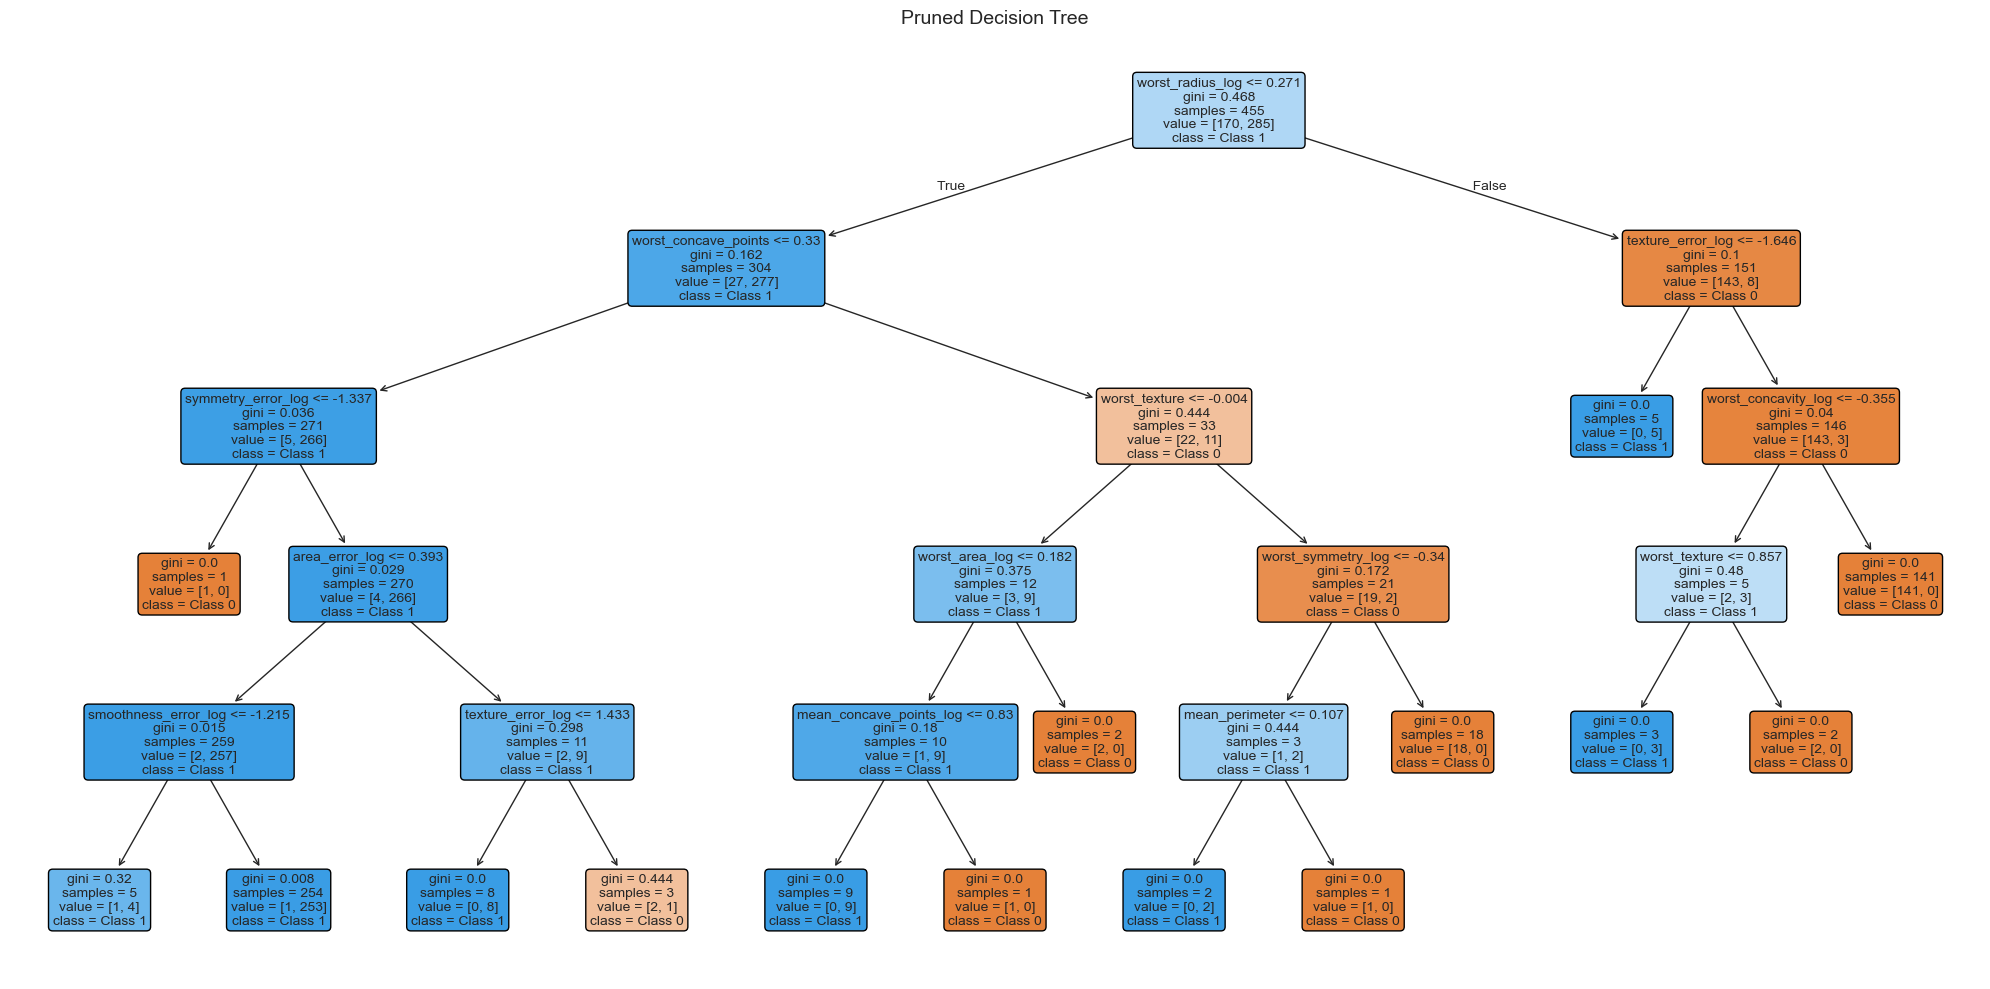

In [85]:
# Plot Pruned Decision Tree
plt.figure(figsize=(20,10))
plot_tree(
    pruned_DT,
    filled=True,
    feature_names=X_train.columns,
    class_names=['Class 0', 'Class 1'],
    rounded=True,
    fontsize=10
)
plt.title("Pruned Decision Tree", fontsize=14)
plt.tight_layout()
plt.show()


### ROC-AUC COMPARISON

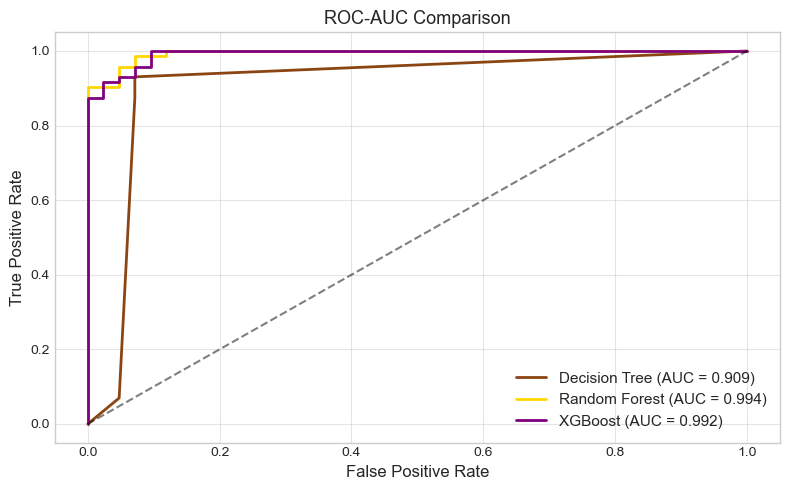

In [86]:
# Obtain probabilities
y_prob_dt = pruned_DT.predict_proba(X_test)[:, 1]
y_prob_rf = vanilla_RF.predict_proba(X_test)[:, 1]
y_prob_xgb = Grid_XGB.predict_proba(X_test)[:, 1]

# Compute ROC curves
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_prob_dt)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)

# Compute AUC scores
auc_dt = roc_auc_score(y_test, y_prob_dt)
auc_rf = roc_auc_score(y_test, y_prob_rf)
auc_xgb = roc_auc_score(y_test, y_prob_xgb)

# Plot
plt.figure(figsize=(8,5))
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {auc_dt:.3f})', color='#8B4513', linewidth=2)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.3f})', color='#FFD700', linewidth=2)
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.3f})', color='#800080', linewidth=2)

# Random classifier line
plt.plot([0,1], [0,1], 'k--', alpha=0.5)

# Styling
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("ROC-AUC Comparison", fontsize=13)
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

*Observation & Interpretation:*

- Random Forest and XGBoost dominate – Both models hug the top-left corner closely, indicating very high true positive rates with minimal false positives. Their AUC scores (0.994 and 0.992) confirm nearly perfect discrimination.

- Decision Tree lags behind – The Decision Tree curve rises more gradually, showing that it struggles more to distinguish between classes compared to ensemble methods. Its AUC of 0.909 is good but clearly inferior.

- **Ensemble methods shine** – The slight edge of Random Forest over XGBoost suggests that, for this dataset, averaging many trees slightly outperforms boosting, although both are extremely strong.

## TUNED MODEL COMPARISON

| Model | Accuracy | Malignant Recall (Class 1) | Benign Recall (Class 0) | Weighted F1-Score |
|-------|---------|----------------------------|------------------------|-----------------|
| Pruned Weighted DT | 91% | 0.90 | 0.93 | 0.91 |
| GridSearchCV RF | 96% | 0.97 | 0.93 | 0.96 |
| Weighted XGBoost | 95% | 0.97 | 0.90 | 0.96 |

### Key Insights

- **Malignant detection**: GridSearchCV RF and Weighted XGBoost miss very few malignant tumors.  
- **Overall performance**: GridSearchCV RF leads slightly in accuracy and balance between classes.  
- **Interpretability vs performance**: Pruned Weighted DT is easier to explain but sacrifices some predictive power.

## FEATURE IMPORTANCE

With our top two models finalized, the next step is to identify which features contributed most to their predictions. Understanding feature relevance helps us interpret model behavior and prioritize key predictors.

### RANDOM FOREST

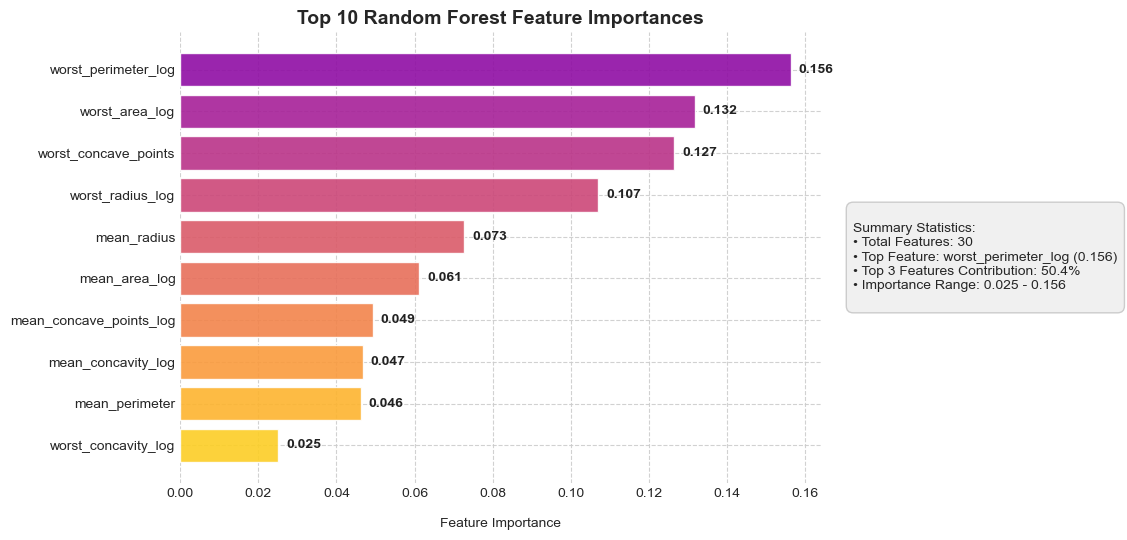

In [87]:
# Extract top 10 feature importances
rf_importances = vanilla_rf.feature_importances_
features = X_train.columns
rf_feat_df = pd.DataFrame({'Feature': features, 'Importance': rf_importances})
rf_feat_df = rf_feat_df.sort_values(by='Importance', ascending=False).head(10)

# Color palette
colors = plt.cm.plasma(np.linspace(0.3, 0.9, len(rf_feat_df)))

# Plot
fig, ax = plt.subplots(figsize=(11.5,5.5))
bars = ax.barh(rf_feat_df['Feature'], rf_feat_df['Importance'], color=colors, edgecolor='white', alpha=0.9)
ax.invert_yaxis()
ax.set_xlabel("Feature Importance", labelpad=13)
ax.set_title("Top 10 Random Forest Feature Importances", fontsize=14, fontweight='semibold')

# Annotate bars
for i, (value, feature) in enumerate(zip(rf_feat_df['Importance'], rf_feat_df['Feature'])):
    ax.text(value + 0.002, i, f"{value:.3f}", va='center', fontweight='bold', color='#222222')

# Summary statistics text box
importance_stats = f"""
Summary Statistics:
• Total Features: {len(features)}
• Top Feature: {rf_feat_df.iloc[0]['Feature']} ({rf_feat_df.iloc[0]['Importance']:.3f})
• Top 3 Features Contribution: {(rf_feat_df.head(3)['Importance'].sum() / rf_feat_df['Importance'].sum() * 100):.1f}%
• Importance Range: {rf_feat_df['Importance'].min():.3f} - {rf_feat_df['Importance'].max():.3f}
"""
ax.text(1.05, 0.5, importance_stats, transform=ax.transAxes, fontsize=10, va='center', ha='left',
        bbox=dict(boxstyle="round,pad=0.5", facecolor='#f0f0f0', edgecolor='#cccccc', linewidth=1))

# Tighten it all up
sns.despine(left=True, bottom=True)
ax.grid(axis='both', linestyle='--', alpha=0.9)
plt.tight_layout()
plt.show()

*Interpretation:*

The model places the greatest weight on the most extreme measurements of each sample; for example the largest perimeter, area or irregularity detected. These ‘worst-case’ values tend to differentiate the classes far more clearly than the averages.

### XGBOOST

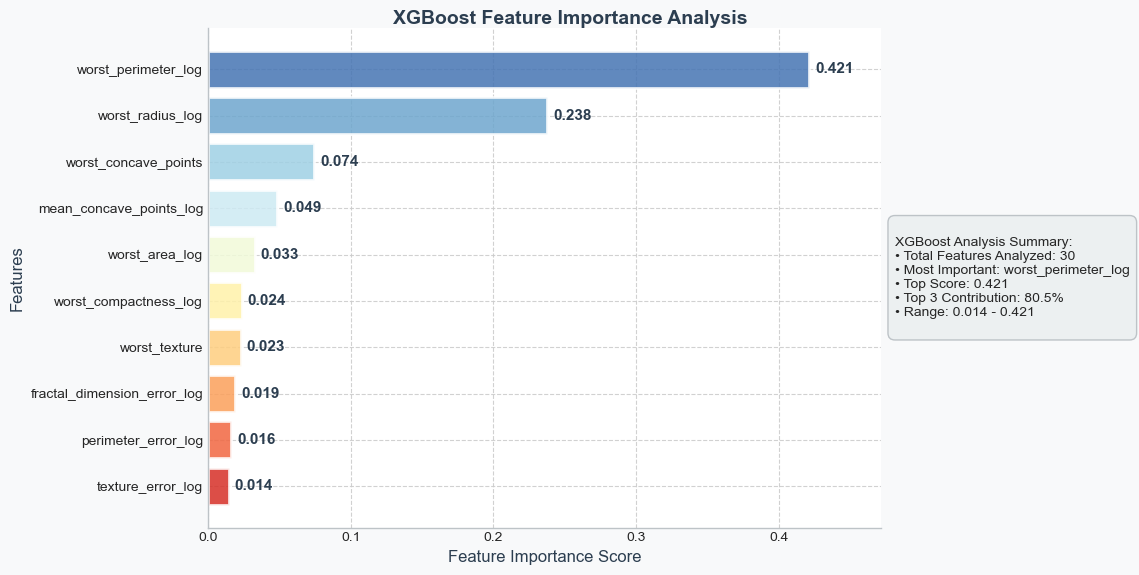

In [88]:
# Extract top 10 feature importances
xgb_importances = vanilla_boost.feature_importances_
features = X_train.columns
xgb_feat_df = pd.DataFrame({'Feature': features, 'Importance': xgb_importances})
xgb_feat_df = xgb_feat_df.sort_values(by='Importance', ascending=False).head(10)

# Palette
colors = plt.cm.RdYlBu_r(np.linspace(0.1, 0.9, len(xgb_feat_df)))

# Plot setup
fig, ax = plt.subplots(figsize=(11.5, 6))
fig.patch.set_facecolor('#f8f9fa')
ax.set_facecolor('#ffffff')

# Plot bars
bars = ax.barh(xgb_feat_df['Feature'], xgb_feat_df['Importance'],
               color=colors, edgecolor='white', linewidth=2, alpha=0.85)

ax.invert_yaxis()

# Labels
ax.set_xlabel("Feature Importance Score", fontsize=12, color='#2c3e50')
ax.set_ylabel("Features", fontsize=12, color='#2c3e50')

# Title
fig.suptitle('XGBoost Feature Importance Analysis',
            fontsize=14, fontweight='semibold', y=0.95, color='#2c3e50')

# Annotate bars
for i, (value, feature) in enumerate(zip(xgb_feat_df['Importance'], xgb_feat_df['Feature'])):
    ax.text(value + max(xgb_feat_df['Importance']) * 0.01, i, f"{value:.3f}",
            va='center', fontweight='semibold', fontsize=11, color='#2c3e50')

# Summary statistics text textbox
importance_stats = f"""
XGBoost Analysis Summary:
• Total Features Analyzed: {len(features)}
• Most Important: {xgb_feat_df.iloc[0]['Feature']}
• Top Score: {xgb_feat_df.iloc[0]['Importance']:.3f}
• Top 3 Contribution: {(xgb_feat_df.head(3)['Importance'].sum() / xgb_feat_df['Importance'].sum() * 100):.1f}%
• Range: {xgb_feat_df['Importance'].min():.3f} - {xgb_feat_df['Importance'].max():.3f}
"""

ax.text(1.02, 0.5, importance_stats, transform=ax.transAxes,
        fontsize=10, va='center', ha='left',
        bbox=dict(boxstyle="round,pad=0.5", facecolor='#ecf0f1',
                 edgecolor='#bdc3c7', linewidth=1))

# Grid styling
ax.grid(axis='both', linestyle='--', alpha=0.9, linewidth=0.8)
ax.set_axisbelow(True)

# Spine styling
for spine in ax.spines.values():
    spine.set_edgecolor('#bdc3c7')
    spine.set_linewidth(1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Set limits with padding
x_max = xgb_feat_df['Importance'].max()
ax.set_xlim(0, x_max * 1.12)

# Final layout
plt.subplots_adjust(left=0.15, right=0.75, top=0.88, bottom=0.1)
plt.tight_layout()
plt.show()

*Interpretation:*

XGBoost concentrates its predictive power on a very small set of “worst-case” measurements:
- Primary driver: worst_perimeter_log alone explains over 42 % of the model’s importance.
- Key secondary factor: worst_radius_log contributes another 24 %.
- Third pillar: worst_concave_points brings the top-three combined contribution to more than 80 % of the total.

# CONCLUSIONS AND RECOMMENDATIONS

## CONCLUSIONS

1. **Decision Trees**  
   - Simple and interpretable but prone to overfitting.  
   - Weighted classes improved performance (accuracy from 89% to 91%), yet they remain less competitive compared to ensemble methods.  

2. **Random Forests**  
   - Provided the most reliable and balanced performance.  
   - Achieved **96% accuracy** with high malignant recall (0.97), making it robust for clinical use.  
   - Handled class imbalance naturally, so additional techniques (weighting/SMOTE) offered little added benefit.  

3. **XGBoost**  
   - Showed excellent stability across all variants.  
   - Weighted XGBoost achieved **96% accuracy with 0.99 recall** on malignant cases, minimizing false negatives.  
   - Stronger at handling imbalance compared to Decision Trees and performed on par with Random Forests.  

4. **Model Comparison (after tuning)**  
   - **Random Forest (GridSearchCV)** slightly outperformed with 96% accuracy, balanced recall, and robust generalization.  
   - **Weighted XGBoost** matched closely, excelling in malignant tumor detection with fewer false negatives.  
   - **Pruned Decision Trees** offered interpretability but at the cost of predictive power (91% accuracy).  

## RECOMMENDATIONS

1. **For Best Overall Performance**  
   - Deploy **Random Forest (with tuning)** for reliable, balanced results and strong generalization.  
   - Alternatively, use **Weighted XGBoost** where **recall of malignant tumors** (critical cases) must be maximized.  

2. **For Clinical Settings**  
   - Prefer **Weighted XGBoost** since missing malignant tumors can have severe consequences.  
   - However, Random Forest remains a safer long-term choice due to stability across datasets.  

3. **Model Maintenance**  
   - Regularly apply **hyperparameter tuning** (e.g., GridSearchCV, RandomizedSearchCV) to adapt to new data.  
   - Use **early stopping in XGBoost** and **tree depth control in Random Forest** to reduce overfitting.  

4. **Interpretability vs Accuracy**  
   - For scenarios requiring explainability (e.g., patient communication), a **pruned weighted Decision Tree** may be used as a supplementary model.  

5. **Future Work**  
   - Explore additional ensemble techniques (e.g., stacking, LightGBM, CatBoost).  
   - Test models on larger and more diverse datasets to confirm robustness.  
   - Investigate **SHAP or LIME** for model interpretability in Random Forest/XGBoost predictions.  